In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalaciones e importaciones
!pip install pyarrow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from imblearn.keras import BalancedBatchGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import RandomOverSampler

# Inspección, Visualización y Prepocesamiento de Datos

## Carga de los datos

**detections_SNe_v7.0.1.csv**

In [ ]:
df_detections = pd.read_csv('/content/drive/MyDrive/8vo Semestre/Inteligencia Computacional/Proyecto 06: Clasificación de Supernovas de ALeRCE - ZTF/datos/detections_SNe_v7.0.1.csv',
                            index_col=0)

df_detections.head()

,objectId,fid,isdiffpos,sigmapsf,field,fwhm,dec,magpsf,rcid,ra,...,sgscore3,neargaia,sgscore1,mjd,corrected,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,dubious,has_stamp
0,ZTF18aahvndq,1,1.0,0.028791,626,3.59,27.008621,15.385100,34,198.722678,...,0.5,78.019280,0.175976,58991.302095,False,NaN,NaN,NaN,False,True
1,ZTF18aahvndq,1,1.0,0.031231,626,2.57,27.008635,15.712121,34,198.722679,...,0.5,78.022800,0.175976,59000.260914,False,NaN,NaN,NaN,False,True
2,ZTF18aahvndq,1,1.0,0.032161,626,1.98,27.008647,16.072975,34,198.722653,...,0.5,78.111310,0.175976,59004.192674,False,NaN,NaN,NaN,False,True
3,ZTF18aahvndq,1,1.0,0.049931,626,2.75,27.008624,17.708502,34,198.722660,...,0.5,78.077545,0.175976,59021.227604,False,NaN,NaN,NaN,False,True
4,ZTF18aahvndq,1,1.0,0.028520,626,3.13,27.008636,15.617474,34,198.722660,...,0.5,78.083150,0.175976,58986.223646,False,NaN,NaN,NaN,False,True


**dfcrossmatches_prioritized_v7.0.1.csv**

In [ ]:
df_crossmatches = pd.read_csv('/content/drive/MyDrive/8vo Semestre/Inteligencia Computacional/Proyecto 06: Clasificación de Supernovas de ALeRCE - ZTF/datos/dfcrossmatches_prioritized_v7.0.1.csv')

df_crossmatches.head()

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990


**features_cleaned.parquet**

In [ ]:
df_features = pd.read_parquet('/content/drive/MyDrive/8vo Semestre/Inteligencia Computacional/Proyecto 06: Clasificación de Supernovas de ALeRCE - ZTF/datos/features_cleaned.parquet')

df_features.head()

,oid,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,...,GP_DRW_tau_g,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3
0,ZTF18aahvndq,84.778146,32.955580,-0.041541,0.246432,NaN,NaN,0.882857,254.265274,26.968182,...,66.362931,0.759076,27.720122,0.175976,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF19abqviuy,-56.280179,109.009059,-0.079274,0.021343,NaN,NaN,0.930000,75.107750,5.551193,...,53.981530,0.542258,92.358918,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF19acyogrm,-24.613587,148.867482,1.280889,0.400809,1.227327,0.502450,0.850000,0.314363,0.056313,...,0.069667,0.385131,49.756570,0.332214,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aaiovoy,42.559095,209.082699,0.178904,0.587743,NaN,NaN,0.887143,13.142984,1.021393,...,18.657369,0.026580,25.050218,0.292830,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20abcqpdj,72.178184,147.837430,0.308870,0.400827,0.498012,0.541368,0.942857,1.128955,0.027010,...,6.547652,0.009291,23.891174,0.000000,0.267,4.391,3.883968,8.274968,3.3426,7.7336


## Preprocesamiento

**dfcrossmatches_prioritized_v7.0.1.csv**

In [ ]:
# Se crea una copia de la columna 'classALeRCE'
df_crossmatches['classALeRCE_modified'] = df_crossmatches['classALeRCE'].copy()

# Se eliminan las columnas que no son de interés
df_crossmatches = df_crossmatches[['oid', 'classALeRCE_modified']]

# Las clases 'SNIIb' y 'SNIIn' se integran a la clase 'SNII'
df_crossmatches['classALeRCE_modified'] = df_crossmatches['classALeRCE_modified'].replace({'SNIIb': 'SNII', 'SNIIn': 'SNII'})

df_crossmatches.head()

,oid,classALeRCE_modified
0,ZTF19abegncu,AGN
1,ZTF18acejdhu,AGN
2,ZTF18acdzene,AGN
3,ZTF18abwzuzw,AGN
4,ZTF19abmposz,AGN


**Union de los dfs**

In [ ]:
# Unir los dataframes usando la columna 'oid'
df_final = pd.merge(df_crossmatches, df_features, on='oid', how='inner')

# 1. Mantener el valor de `oid`
oids = df_final['oid'].values  # Extraer el valor de `oid` antes de cualquier preprocesamiento

# Eliminar la columna 'oid' del dataframe
df_final = df_final.drop('oid', axis=1)

# Se conservan las features que son de interés
columnas_a_conservar = [
    "classALeRCE_modified", "SPM_t0_g", "SPM_gamma_r", "SPM_tau_rise_r", "SPM_tau_rise_g",
    "g-r_max_g_r", "SPM_t0_r", "LinearTrend_r", "AndersonDarling_r", "SPM_gamma_g",
    "SPM_tau_fall_r", "dmag_first_det_fid_g", "MHPS_low_g", "LinearTrend_g", "g-r_mean_g_r",
    "MHPS_ratio_g", "SPM_tau_fall_g", "SPM_beta_r", "MHPS_ratio_r", "Skew_r", "sgscore1",
    "SPM_beta_g", "Power_rate_2_g_r", "IAR_phi_r", "dmag_first_det_fid_r", "IAR_phi_g",
    "last_diffmaglim_before_fid_g", "PPE_g_r", "Harmonics_mag_6_g", "MHPS_low_r", "Gskew_r"
]

# Filtra el DataFrame conservando solo las columnas especificadas
df_final = df_final[columnas_a_conservar]

df_final.head()

,classALeRCE_modified,SPM_t0_g,SPM_gamma_r,SPM_tau_rise_r,SPM_tau_rise_g,g-r_max_g_r,SPM_t0_r,LinearTrend_r,AndersonDarling_r,SPM_gamma_g,...,SPM_beta_g,Power_rate_2_g_r,IAR_phi_r,dmag_first_det_fid_r,IAR_phi_g,last_diffmaglim_before_fid_g,PPE_g_r,Harmonics_mag_6_g,MHPS_low_r,Gskew_r
0,SLSN,22.508353,63.647832,14.361754,15.288365,-0.080040,17.863513,0.009794,0.999599,44.320302,...,0.682780,0.926502,0.987724,0.342186,0.990150,20.1085,0.308221,4904.368775,4.765296,0.351121
1,SLSN,49.619670,99.999994,27.118114,100.000000,-0.032061,49.999995,0.007994,1.000000,38.917478,...,0.405077,1.000000,0.997388,NaN,0.999077,NaN,0.194865,0.353844,0.157985,-1.433249
2,SLSN,20.148920,66.150400,25.696962,11.934572,0.096467,35.076897,-0.011920,0.295506,78.541453,...,0.213617,1.000000,0.983884,0.103896,0.981974,19.3117,0.055679,313.376778,7.490531,-0.033833
3,SLSN,-16.330852,30.404730,6.852037,16.901117,0.153276,5.962431,0.000000,0.429023,22.429234,...,0.200191,0.010837,0.861366,-0.423851,NaN,19.0389,0.034898,3.173047,0.199374,0.331859
4,SLSN,34.914903,21.373601,13.716046,14.818059,-0.034018,32.233622,0.005743,0.863901,10.026746,...,0.645142,0.818687,0.980307,1.484128,0.990031,17.8644,0.055233,3.115758,3.231577,-0.272838


**dfs para el modelo**

In [ ]:
# Resultados que el modelo debe predecir
df_classes = df_final['classALeRCE_modified']

df_classes.head()

,classALeRCE_modified
0,SLSN
1,SLSN
2,SLSN
3,SLSN
4,SLSN


In [ ]:
# Copia del df final para entregar al modelo
df_featuresX = df_final.copy()

# Los valores NaN se rellenan con -999
df_featuresX = df_featuresX.fillna(-999)

# Se elimina la columna que contiene las clases
df_featuresX = df_featuresX.drop('classALeRCE_modified', axis=1)

df_featuresX.head()

,SPM_t0_g,SPM_gamma_r,SPM_tau_rise_r,SPM_tau_rise_g,g-r_max_g_r,SPM_t0_r,LinearTrend_r,AndersonDarling_r,SPM_gamma_g,SPM_tau_fall_r,...,SPM_beta_g,Power_rate_2_g_r,IAR_phi_r,dmag_first_det_fid_r,IAR_phi_g,last_diffmaglim_before_fid_g,PPE_g_r,Harmonics_mag_6_g,MHPS_low_r,Gskew_r
0,22.508353,63.647832,14.361754,15.288365,-0.080040,17.863513,0.009794,0.999599,44.320302,31.037493,...,0.682780,0.926502,0.987724,0.342186,0.990150,20.1085,0.308221,4904.368775,4.765296,0.351121
1,49.619670,99.999994,27.118114,100.000000,-0.032061,49.999995,0.007994,1.000000,38.917478,99.999991,...,0.405077,1.000000,0.997388,-999.000000,0.999077,-999.0000,0.194865,0.353844,0.157985,-1.433249
2,20.148920,66.150400,25.696962,11.934572,0.096467,35.076897,-0.011920,0.295506,78.541453,5.445822,...,0.213617,1.000000,0.983884,0.103896,0.981974,19.3117,0.055679,313.376778,7.490531,-0.033833
3,-16.330852,30.404730,6.852037,16.901117,0.153276,5.962431,0.000000,0.429023,22.429234,97.049420,...,0.200191,0.010837,0.861366,-0.423851,-999.000000,19.0389,0.034898,3.173047,0.199374,0.331859
4,34.914903,21.373601,13.716046,14.818059,-0.034018,32.233622,0.005743,0.863901,10.026746,96.639485,...,0.645142,0.818687,0.980307,1.484128,0.990031,17.8644,0.055233,3.115758,3.231577,-0.272838


## Visualización de los Datos

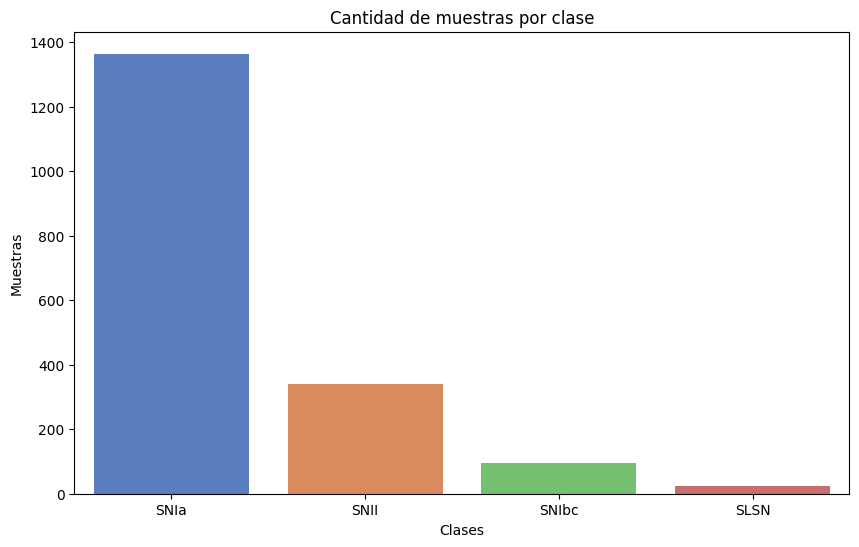

In [ ]:
# Visualizar la cantidad de datos para cada clase
count_classes = df_classes.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=count_classes.index, y=count_classes.values, hue=df_classes.unique(), palette="muted", legend=False)
plt.title('Cantidad de muestras por clase')
plt.xlabel('Clases')
plt.ylabel('Muestras')
plt.show()

In [ ]:
# Cantidad de datos para cada clase
print('Cantidad de muestras por clase')
print(df_classes.value_counts())
print('Número total muestras:', df_classes.value_counts().sum())

Cantidad de muestras por clase
classALeRCE_modified
SNIa     1364
SNII      339
SNIbc      96
SLSN       24
Name: count, dtype: int64
Número total muestras: 1823


In [ ]:
# Features
print('Features:', np.array(df_featuresX.columns))
print('Cantidad de features:', len(np.array(df_featuresX.columns)))

Features: ['SPM_t0_g' 'SPM_gamma_r' 'SPM_tau_rise_r' 'SPM_tau_rise_g' 'g-r_max_g_r'
 'SPM_t0_r' 'LinearTrend_r' 'AndersonDarling_r' 'SPM_gamma_g'
 'SPM_tau_fall_r' 'dmag_first_det_fid_g' 'MHPS_low_g' 'LinearTrend_g'
 'g-r_mean_g_r' 'MHPS_ratio_g' 'SPM_tau_fall_g' 'SPM_beta_r'
 'MHPS_ratio_r' 'Skew_r' 'sgscore1' 'SPM_beta_g' 'Power_rate_2_g_r'
 'IAR_phi_r' 'dmag_first_det_fid_r' 'IAR_phi_g'
 'last_diffmaglim_before_fid_g' 'PPE_g_r' 'Harmonics_mag_6_g' 'MHPS_low_r'
 'Gskew_r']
Cantidad de features: 30


# **MLP en Pytorch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df_featuresX.head()



,SPM_t0_g,SPM_gamma_r,SPM_tau_rise_r,SPM_tau_rise_g,g-r_max_g_r,SPM_t0_r,LinearTrend_r,AndersonDarling_r,SPM_gamma_g,SPM_tau_fall_r,...,SPM_beta_g,Power_rate_2_g_r,IAR_phi_r,dmag_first_det_fid_r,IAR_phi_g,last_diffmaglim_before_fid_g,PPE_g_r,Harmonics_mag_6_g,MHPS_low_r,Gskew_r
0,22.508353,63.647832,14.361754,15.288365,-0.080040,17.863513,0.009794,0.999599,44.320302,31.037493,...,0.682780,0.926502,0.987724,0.342186,0.990150,20.1085,0.308221,4904.368775,4.765296,0.351121
1,49.619670,99.999994,27.118114,100.000000,-0.032061,49.999995,0.007994,1.000000,38.917478,99.999991,...,0.405077,1.000000,0.997388,-999.000000,0.999077,-999.0000,0.194865,0.353844,0.157985,-1.433249
2,20.148920,66.150400,25.696962,11.934572,0.096467,35.076897,-0.011920,0.295506,78.541453,5.445822,...,0.213617,1.000000,0.983884,0.103896,0.981974,19.3117,0.055679,313.376778,7.490531,-0.033833
3,-16.330852,30.404730,6.852037,16.901117,0.153276,5.962431,0.000000,0.429023,22.429234,97.049420,...,0.200191,0.010837,0.861366,-0.423851,-999.000000,19.0389,0.034898,3.173047,0.199374,0.331859
4,34.914903,21.373601,13.716046,14.818059,-0.034018,32.233622,0.005743,0.863901,10.026746,96.639485,...,0.645142,0.818687,0.980307,1.484128,0.990031,17.8644,0.055233,3.115758,3.231577,-0.272838


In [ ]:
# Se le asocia un número a cada clase
class_mapping = {'SNIa': 0, 'SNII': 1, 'SNIbc': 2, 'SLSN': 3}
df_final['classALeRCE_modified_num'] = df_final['classALeRCE_modified'].map(class_mapping)

# Crear el DataFrame con la columna
df_classes_num = df_final[['classALeRCE_modified_num']]
df_classes_num.head()

,classALeRCE_modified_num
0,3
1,3
2,3
3,3
4,3


In [ ]:
# Verificar los valores únicos en `classALeRCE_modified_num` antes del mapeo
print("Valores únicos en `classALeRCE_modified_num` antes del mapeo:", df_classes_num['classALeRCE_modified_num'].unique())


Valores únicos en `classALeRCE_modified_num` antes del mapeo: [3 1 0 2]


In [ ]:
# Convertir las características y etiquetas a numpy arrays
featuresX = df_featuresX.values  # Características (X)
classes = df_classes_num['classALeRCE_modified_num'].values  # Etiquetas (Y)

# Verificar tamaños
print("Tamaño de featuresX:", featuresX.shape)  # Debe ser (1823, 30) si tienes 1823 ejemplos
print("Tamaño de classes:", classes.shape)      # Debe ser (1823,)


Tamaño de featuresX: (1823, 30)
Tamaño de classes: (1823,)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Paso 1: Configuración inicial de datos
scaler = StandardScaler()
X = scaler.fit_transform(featuresX)  # Suponiendo que 'featuresX' ya está definido
y = np.eye(4)[classes]  # Convertir clases a one-hot encoding
X_train, X_test, y_train, y_test, oid_train, oid_test = train_test_split(X, y, oids, test_size=0.2, stratify=classes)

# Convertir las etiquetas 'y_train' y 'y_test' a formato adecuado
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Paso 2: Calcular las frecuencias de las clases en el conjunto de entrenamiento
class_counts = torch.bincount(y_train_tensor)  # Cuenta las ocurrencias de cada clase
class_weights = 1.0 / class_counts.float()  # Calcula el peso inverso de cada clase
class_weights = class_weights / class_weights.sum()  # Normaliza los pesos

# Paso 3: Definir el sampler ponderado
class WeightedRandomSampler(Sampler):
    def __init__(self, labels, class_weights):
        self.labels = labels
        self.class_weights = class_weights

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        # Asignar un peso a cada índice según la clase
        sample_weights = self.class_weights[self.labels]
        # Seleccionar índices según los pesos (muestreo ponderado)
        indices = torch.multinomial(sample_weights, len(sample_weights), replacement=True)
        return iter(indices)

# Paso 4: Crear el DataLoader con el sampler ponderado
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Usar el sampler ponderado para balancear las clases
train_sampler = WeightedRandomSampler(y_train_tensor, class_weights)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)  # Con el sampler ponderado
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Sin sampler, ya que solo es para validación

# Paso 5: Ahora puedes usar el DataLoader para entrenar tu modelo
for batch_idx, (data, target) in enumerate(train_loader):
    # Aquí puedes pasar 'data' y 'target' a tu modelo
    pass



In [ ]:

"""
# Configuración inicial de datos
scaler = StandardScaler()
X = scaler.fit_transform(featuresX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=classes)

# Balancear las clases
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train_resampled, axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Crear DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""

"\n# Configuración inicial de datos\nscaler = StandardScaler()\nX = scaler.fit_transform(featuresX)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=classes)\n\n# Balancear las clases\nros = RandomOverSampler(sampling_strategy='auto', random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Convertir a tensores de PyTorch\nX_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)\ny_train_tensor = torch.tensor(np.argmax(y_train_resampled, axis=1), dtype=torch.long)\nX_test_tensor = torch.tensor(X_test, dtype=torch.float32)\ny_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)\n\n# Crear DataLoaders\nbatch_size = 64\ntrain_dataset = TensorDataset(X_train_tensor, y_train_tensor)\ntest_dataset = TensorDataset(X_test_tensor, y_test_tensor)\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuff

In [ ]:
import numpy as np
from collections import Counter

# Contar las muestras por clase en el conjunto de entrenamiento balanceado
class_counts_train = Counter(y_train_tensor.numpy())
print("Cantidad de elementos por clase en el conjunto de entrenamiento balanceado:")
for class_id, count in sorted(class_counts_train.items()):
    print(f"Clase {class_id}: {count}")

# Contar las muestras por clase en el conjunto de prueba (sin balancear)
class_counts_test = Counter(y_test_tensor.numpy())
print("\nCantidad de elementos por clase en el conjunto de prueba:")
for class_id, count in sorted(class_counts_test.items()):
    print(f"Clase {class_id}: {count}")


Cantidad de elementos por clase en el conjunto de entrenamiento balanceado:
Clase 0: 1091
Clase 1: 271
Clase 2: 77
Clase 3: 19

Cantidad de elementos por clase en el conjunto de prueba:
Clase 0: 273
Clase 1: 68
Clase 2: 19
Clase 3: 5


In [ ]:
class_count = torch.zeros(len(torch.unique(y_train_tensor)))  # Cuenta las clases
for _, target in train_loader:
    for label in target:
        class_count[label] += 1

print(class_count)


tensor([371., 369., 353., 365.])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el modelo
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Normalización de la capa 1
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Normalización de la capa 2
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Aplicar BN después de cada capa lineal
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Configuración del dispositivo para usar GPU si está disponible, de lo contrario usa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciar el modelo y moverlo al dispositivo adecuado (GPU o CPU)
input_dim = X_train_tensor.shape[1]
output_dim = 4
model = MLP(input_dim, output_dim).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Inicializar listas para almacenar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Entrenamiento
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        # Mover los datos al dispositivo (GPU o CPU)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Realizar la inferencia
        outputs = model(X_batch)

        # Calcular la pérdida
        loss = criterion(outputs, y_batch)

        # Retropropagación
        loss.backward()
        optimizer.step()

        # Acumular la pérdida y las métricas de precisión
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    # Guardar las métricas para la época actual
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # No necesitamos gradientes en la fase de validación
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Realizar la inferencia
            outputs = model(X_batch)

            # Calcular la pérdida
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    # Guardar las métricas de validación
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct_val / total_val)

    # Mostrar el progreso de la época
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch [1/100], Train Loss: 1.4531, Train Accuracy: 29.49%, Val Loss: 1.3521, Val Accuracy: 23.01%
Epoch [2/100], Train Loss: 1.4003, Train Accuracy: 31.76%, Val Loss: 1.3206, Val Accuracy: 32.05%
Epoch [3/100], Train Loss: 1.3812, Train Accuracy: 33.40%, Val Loss: 1.2974, Val Accuracy: 37.26%
Epoch [4/100], Train Loss: 1.3585, Train Accuracy: 37.04%, Val Loss: 1.2792, Val Accuracy: 39.45%
Epoch [5/100], Train Loss: 1.3061, Train Accuracy: 39.09%, Val Loss: 1.2559, Val Accuracy: 45.48%
Epoch [6/100], Train Loss: 1.3083, Train Accuracy: 40.67%, Val Loss: 1.2498, Val Accuracy: 47.12%
Epoch [7/100], Train Loss: 1.2789, Train Accuracy: 40.40%, Val Loss: 1.2193, Val Accuracy: 51.23%
Epoch [8/100], Train Loss: 1.2801, Train Accuracy: 40.19%, Val Loss: 1.2147, Val Accuracy: 52.05%
Epoch [9/100], Train Loss: 1.2404, Train Accuracy: 44.86%, Val Loss: 1.1812, Val Accuracy: 54.52%
Epoch [10/100], Train Loss: 1.2233, Train Accuracy: 44.65%, Val Loss: 1.2003, Val Accuracy: 52.05%
Epoch [11/100], Tra

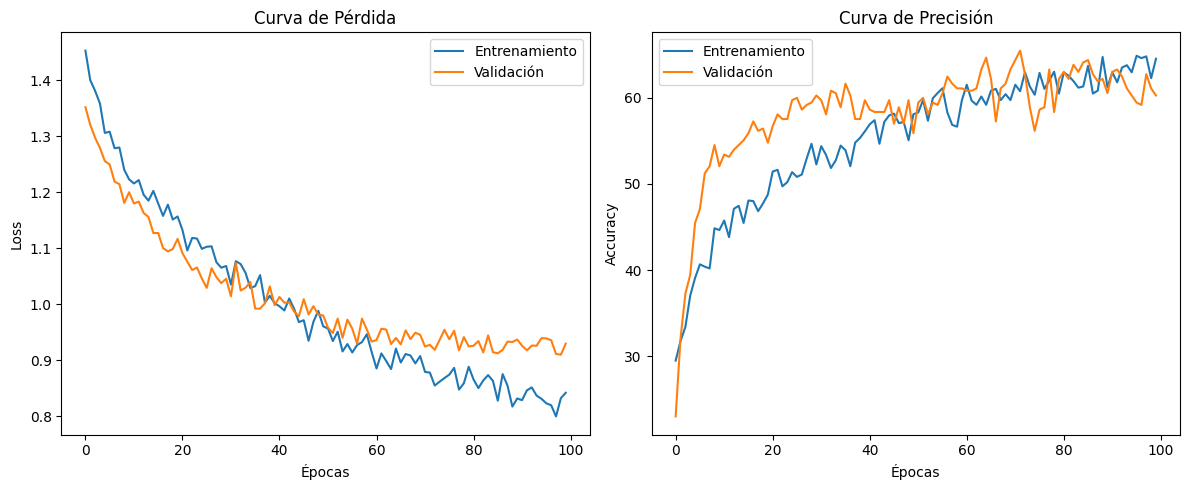

In [ ]:
# Graficar pérdida y precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Entrenamiento')
plt.plot(val_accuracies, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Curva de Precisión')
plt.legend()

plt.tight_layout()
plt.show()


Accuracy: 0.6027
Precision: 0.8105
Recall: 0.6027
F1 Score: 0.6789


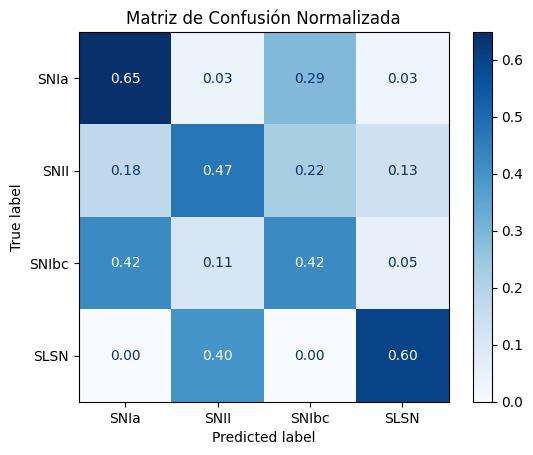

In [ ]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegúrate de que el modelo esté en el dispositivo correcto
model.to(device)

# Validación
model.eval()  # Asegúrate de cambiar a modo de evaluación
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Mover los datos al dispositivo adecuado
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Realizar la inferencia
        outputs = model(X_batch)

        # Obtener las predicciones
        _, predicted = torch.max(outputs, 1)

        # Guardar las predicciones y las etiquetas verdaderas
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
# Convertir a arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_mapping.values())
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Matriz de Confusión Normalizada")
plt.show()


In [ ]:
# Guardar los pesos del modelo MLP pre-entrenado
torch.save(model.state_dict(), "mlp_pretrained.pth")


# **Multi Class Depp SVDD**

In [ ]:
class DeepSVDD(nn.Module):
    def __init__(self, encoder, cls_loss, classes=4, latent_dim=128):
        super(DeepSVDD, self).__init__()
        self.encoder = encoder
        self.register_buffer('c', torch.zeros(classes, latent_dim))  # Centros para cada clase
        self.classes = classes
        self.cls_loss = cls_loss
        self.cls = nn.Linear(latent_dim, classes)

    def forward(self, x):
        return self.encoder(x)

    def forward_classifier(self, x):
        x = self.encoder(x)
        return self.cls(x)

    def set_c(self, dataloader, device, eps=0.01):
        """
        Calcula los centros iniciales para cada clase en el espacio latente.
        """
        self.eval()
        latents, labels = self.get_latent_space(dataloader, device)
        c = []
        for i in range(self.classes):
            ixs = torch.where(labels == i)
            c_j = torch.mean(latents[ixs], dim=0)
            c.append(c_j)
        for i in range(len(c)):
            c[i][(abs(c[i]) < eps) & (c[i] < 0)] = -eps
            c[i][(abs(c[i]) < eps) & (c[i] > 0)] = eps
        self.c = torch.stack(c).to(device)

    def get_latent_space(self, dataloader, device):
        """
        Obtiene las representaciones latentes y etiquetas del dataloader.
        """
        latents, labels = [], []
        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(device).view(x.size(0), -1)
                y = y.to(device)
                z = self.forward(x)
                latents.append(z)
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)

    def compute_loss(self, x, y):
        """
        Compute MSE Loss.
        """
        z = self.forward(x)
        self.loss = torch.mean(torch.sum((z - self.c[y]) ** 2, dim=1))
        return self.loss

    def compute_cls_loss(self, x, y):
        """
        Calcula la pérdida del clasificador.
        """
        z = self.forward_classifier(x)
        return self.cls_loss(z, y)

    def compute_anomaly_score(self, x):
        """
        Calcula el puntaje de anomalía basado en la distancia al centro más cercano.
        """
        z = self.forward(x)
        distances = torch.sum((z.unsqueeze(1) - self.c) ** 2, dim=2)
        return torch.min(distances, dim=1)[0]

    def get_pseudo_labels(self, dataloader, device):
        """
        Genera pseudo-etiquetas basadas en las distancias al centro más cercano.
        """
        latents, labels = self.get_latent_space(dataloader, device)
        distances = torch.sum((latents.unsqueeze(1) - self.c) ** 2, dim=2)
        return torch.argmin(distances, dim=1)


In [ ]:
class MLP_Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(MLP_Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Primera capa oculta
        self.bn1 = nn.BatchNorm1d(256)        # Batch normalization para la primera capa
        self.dropout1 = nn.Dropout(0.5)       # Regularización con dropout

        self.fc2 = nn.Linear(256, latent_dim)  # Segunda capa oculta
        self.bn2 = nn.BatchNorm1d(latent_dim)  # Batch normalization para la segunda capa
        self.dropout2 = nn.Dropout(0.5)       # Regularización con dropout

    def forward(self, x):
        # Primera capa
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout1(x)

        # Segunda capa
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout2(x)

        return x  # Salida del espacio latente


# **Entrenamientos**

In [ ]:
# Asegúrate de que `input_dim` está definido
input_dim = X_train_tensor.shape[1]  # Número de características (columnas) de X_train_tensor

# Crear el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_svdd = DeepSVDD(
    encoder=MLP_Encoder(input_dim=input_dim),  # Sólo pasa input_dim
    cls_loss=nn.CrossEntropyLoss(),
    classes=4,
    latent_dim=128  # Este parámetro no se pasa a MLP_Encoder, se maneja internamente
)
deep_svdd.to(device)


DeepSVDD(
  (encoder): MLP_Encoder(
    (fc1): Linear(in_features=30, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (cls_loss): CrossEntropyLoss()
  (cls): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# Configurar los centros utilizando las representaciones latentes del conjunto de entrenamiento
deep_svdd.set_c(train_loader, device)

In [ ]:
# Optimización
optimizer_cls = torch.optim.Adam(deep_svdd.parameters(), lr=0.001)
epochs_cls = 50  # Número de épocas para clasificación supervisada

# Entrenamiento supervisado
for epoch in range(epochs_cls):
    deep_svdd.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Reiniciar gradientes
        optimizer_cls.zero_grad()

        # Calcular la pérdida de clasificación
        cls_loss = deep_svdd.compute_cls_loss(X_batch, y_batch)

        # Optimización
        cls_loss.backward()
        optimizer_cls.step()

        running_loss += cls_loss.item()

    print(f"Epoch {epoch + 1}/{epochs_cls}, cls_loss: {running_loss / len(train_loader):.4f}")


Epoch 1/50, cls_loss: 1.3716
Epoch 2/50, cls_loss: 1.2354
Epoch 3/50, cls_loss: 1.1345
Epoch 4/50, cls_loss: 1.0835
Epoch 5/50, cls_loss: 1.0360
Epoch 6/50, cls_loss: 1.0312
Epoch 7/50, cls_loss: 0.9805
Epoch 8/50, cls_loss: 0.9125
Epoch 9/50, cls_loss: 0.8885
Epoch 10/50, cls_loss: 0.8538
Epoch 11/50, cls_loss: 0.8566
Epoch 12/50, cls_loss: 0.8657
Epoch 13/50, cls_loss: 0.8126
Epoch 14/50, cls_loss: 0.7821
Epoch 15/50, cls_loss: 0.7837
Epoch 16/50, cls_loss: 0.8025
Epoch 17/50, cls_loss: 0.8141
Epoch 18/50, cls_loss: 0.7889
Epoch 19/50, cls_loss: 0.7617
Epoch 20/50, cls_loss: 0.7640
Epoch 21/50, cls_loss: 0.7655
Epoch 22/50, cls_loss: 0.7594
Epoch 23/50, cls_loss: 0.7302
Epoch 24/50, cls_loss: 0.7583
Epoch 25/50, cls_loss: 0.7232
Epoch 26/50, cls_loss: 0.7519
Epoch 27/50, cls_loss: 0.7644
Epoch 28/50, cls_loss: 0.7514
Epoch 29/50, cls_loss: 0.7168
Epoch 30/50, cls_loss: 0.7685
Epoch 31/50, cls_loss: 0.7172
Epoch 32/50, cls_loss: 0.7169
Epoch 33/50, cls_loss: 0.7124
Epoch 34/50, cls_lo

              precision    recall  f1-score   support

        SNIa       0.91      0.63      0.75       273
        SNII       0.74      0.66      0.70        68
       SNIbc       0.08      0.42      0.14        19
        SLSN       0.14      0.60      0.23         5

    accuracy                           0.62       365
   macro avg       0.47      0.58      0.45       365
weighted avg       0.83      0.62      0.70       365



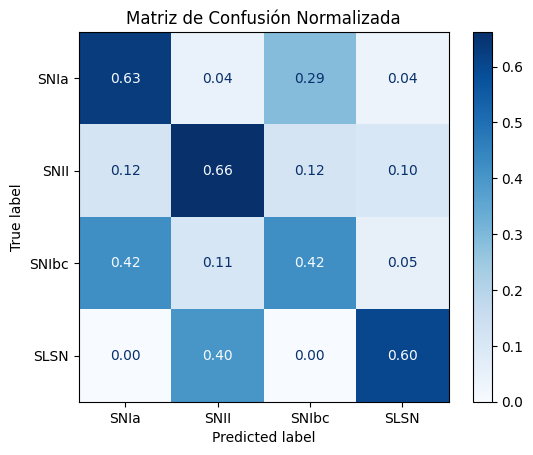

In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_true = []
y_pred = []

deep_svdd.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Predicciones usando el clasificador del DeepSVDD
        outputs = deep_svdd.forward_classifier(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=['SNIa', 'SNII', 'SNIbc', 'SLSN']))

# Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizar por fila

# Mostrar matriz de confusión normalizada
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['SNIa', 'SNII', 'SNIbc', 'SLSN'])
disp.plot(cmap='Blues', values_format=".2f")  # Formato decimal para los valores normalizados
plt.title("Matriz de Confusión Normalizada")
plt.show()


In [ ]:
# Configurar los centros utilizando las representaciones latentes del conjunto de entrenamiento
deep_svdd.set_c(train_loader, device)


In [ ]:
# Extraer el espacio latente y las etiquetas
latents, labels = deep_svdd.get_latent_space(train_loader, device)

# Verifica las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")


Dimensiones del espacio latente: torch.Size([1458, 128])


Dimensiones del espacio latente: (1458, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Dimensiones del espacio reducido: (1458, 2)


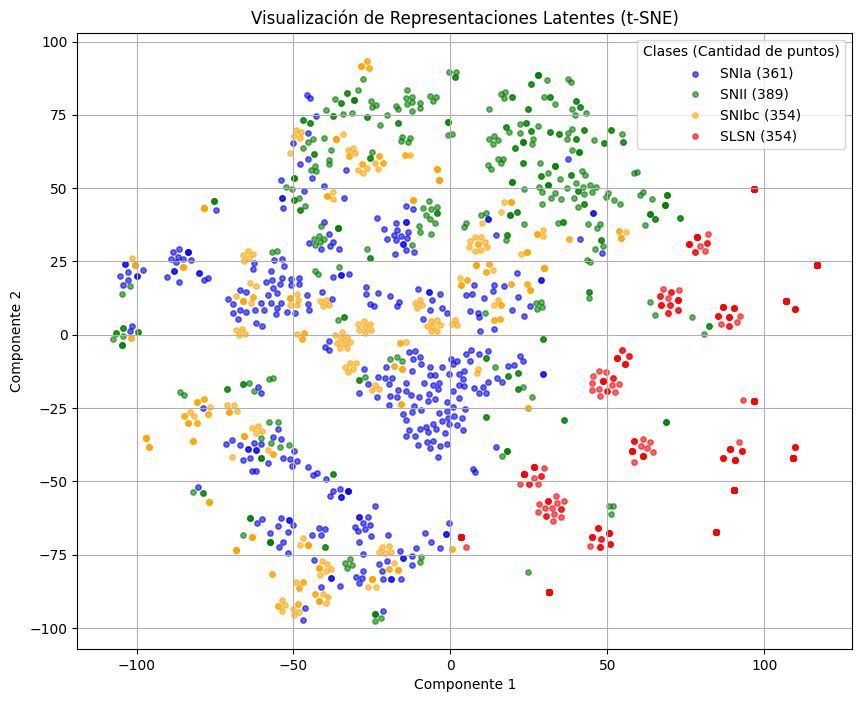

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes del conjunto de entrenamiento
latents = []
labels = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:  # Aquí usamos el train_loader para obtener los datos de entrenamiento
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir a arrays
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
latents_2d = tsne.fit_transform(latents)

# Guardar las representaciones latentes reducidas y sus etiquetas
reduced_latents = torch.tensor(latents_2d, dtype=torch.float32).to(device)
reduced_labels = torch.tensor(labels, dtype=torch.long).to(device)


# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapear colores para las clases
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Calcular la cantidad de puntos por clase
class_counts = {class_mapping[class_id]: np.sum(labels == class_id) for class_id in np.unique(labels)}

# Graficar
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=f"{class_mapping[class_id]} ({class_counts[class_mapping[class_id]]})",
                alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (t-SNE)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases (Cantidad de puntos)")
plt.grid(True)
plt.show()


Dimensiones del espacio latente: (365, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Dimensiones del espacio reducido: (365, 2)


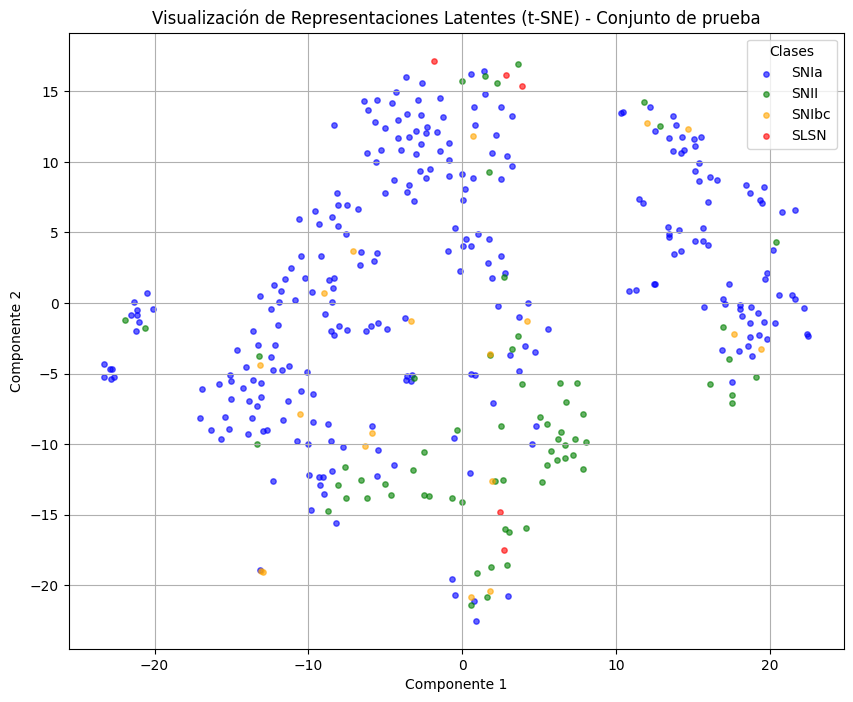

In [ ]:
# Extraer representaciones latentes del conjunto de prueba
latents = []
labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir a arrays
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
latents_2d = tsne.fit_transform(latents)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapear colores para las clases
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Graficar
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (t-SNE) - Conjunto de prueba")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


In [ ]:
# Configurar los centros utilizando las representaciones latentes del conjunto de entrenamiento
#deep_svdd.set_c(train_loader, device)


In [ ]:
# Definir el optimizador
optimizer = torch.optim.Adam(deep_svdd.parameters(), lr=0.001)

# Ciclo de entrenamiento
num_epochs = 100
for epoch in range(num_epochs):
    deep_svdd.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Cálculo de la pérdida en el espacio latente
        loss = deep_svdd.compute_loss(X_batch, y_batch)  # Pasar tanto X_batch como y_batch

        # Gradientes y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Mostrar el progreso
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/100], Loss: 78.0028
Epoch [2/100], Loss: 48.7514
Epoch [3/100], Loss: 33.0252
Epoch [4/100], Loss: 26.8258
Epoch [5/100], Loss: 22.4335
Epoch [6/100], Loss: 21.2113
Epoch [7/100], Loss: 21.2358
Epoch [8/100], Loss: 21.7253
Epoch [9/100], Loss: 19.3063
Epoch [10/100], Loss: 18.8868
Epoch [11/100], Loss: 21.2966
Epoch [12/100], Loss: 20.0028
Epoch [13/100], Loss: 20.0930
Epoch [14/100], Loss: 19.6271
Epoch [15/100], Loss: 20.4404
Epoch [16/100], Loss: 18.0965
Epoch [17/100], Loss: 18.4060
Epoch [18/100], Loss: 20.7771
Epoch [19/100], Loss: 18.6418
Epoch [20/100], Loss: 19.4863
Epoch [21/100], Loss: 18.5408
Epoch [22/100], Loss: 18.4438
Epoch [23/100], Loss: 18.0664
Epoch [24/100], Loss: 19.0074
Epoch [25/100], Loss: 19.2796
Epoch [26/100], Loss: 18.4754
Epoch [27/100], Loss: 18.6067
Epoch [28/100], Loss: 18.0809
Epoch [29/100], Loss: 18.2232
Epoch [30/100], Loss: 18.1129
Epoch [31/100], Loss: 18.2788
Epoch [32/100], Loss: 18.4634
Epoch [33/100], Loss: 18.6006
Epoch [34/100], Los

In [ ]:
# Obtener representaciones latentes y etiquetas del conjunto de entrenamiento
latents_train, labels_train = deep_svdd.get_latent_space(train_loader, device)
print(f"Dimensiones del espacio latente para el conjunto de entrenamiento: {latents_train.shape}")


Dimensiones del espacio latente para el conjunto de entrenamiento: torch.Size([1458, 128])


Dimensiones del espacio latente: (1458, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Dimensiones del espacio reducido: (1458, 2)


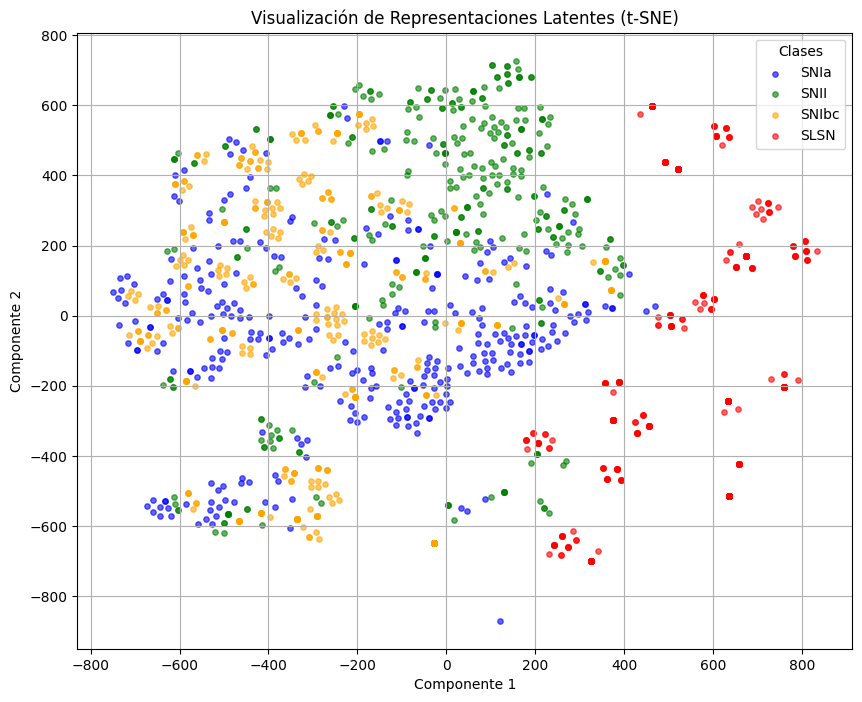

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de entrenamiento
latents = []
labels = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
latents_2d = tsne.fit_transform(latents)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapeo de clases a etiquetas
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Graficar las representaciones latentes reducidas
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (t-SNE)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


In [ ]:
"""
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de entrenamiento
latents = []
labels = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
latents_2d = tsne.fit_transform(latents)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapeo de clases a etiquetas
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Graficar las representaciones latentes reducidas
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

    # Calcular y graficar el centroide de cada clase
    class_latents = latents_2d[idxs]  # Puntos de la clase actual
    centroid = class_latents.mean(axis=0)  # Centroide de la clase
    plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100, label=f'Centroid {class_mapping[class_id]}')

plt.title("Visualización de Representaciones Latentes (t-SNE) con Centroides")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()
"""

'\nfrom sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Configuración: modo evaluación\ndeep_svdd.eval()\n\n# Extraer representaciones latentes y etiquetas del conjunto de entrenamiento\nlatents = []\nlabels = []\n\n# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación\nwith torch.no_grad():\n    for X_batch, y_batch in train_loader:\n        X_batch = X_batch.to(device)\n        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes\n        latents.append(latents_batch)\n        labels.append(y_batch.numpy())\n\n# Convertir las listas a arrays numpy\nlatents = np.vstack(latents)  # (n_samples, latent_dim)\nlabels = np.hstack(labels)    # (n_samples,)\n\n# Imprimir las dimensiones del espacio latente\nprint(f"Dimensiones del espacio latente: {latents.shape}")\n\n# Reducir a 2 dimensiones usando t-SNE\ntsne = TSNE(n_components=2, perplexity=30, n_iter=5000)\nlatents_2d = tsne.fit_

Dimensiones del espacio latente (conjunto de prueba): (365, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Dimensiones del espacio reducido (conjunto de prueba): (365, 2)


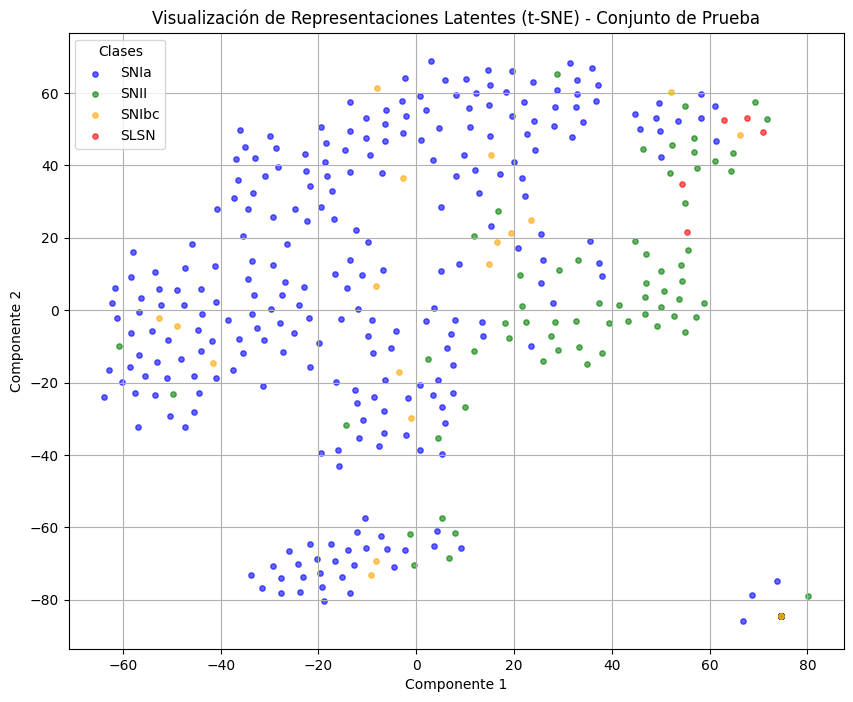

In [ ]:
# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de prueba
latents_test = []
labels_test = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents_test.append(latents_batch)
        labels_test.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents_test = np.vstack(latents_test)  # (n_samples, latent_dim)
labels_test = np.hstack(labels_test)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente (conjunto de prueba): {latents_test.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne_test = TSNE(n_components=2, perplexity=30, n_iter=1000)
latents_2d_test = tsne_test.fit_transform(latents_test)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido (conjunto de prueba): {latents_2d_test.shape}")

# Graficar las representaciones latentes reducidas del conjunto de prueba
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels_test):
    idxs = labels_test == class_id
    plt.scatter(latents_2d_test[idxs, 0], latents_2d_test[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (t-SNE) - Conjunto de Prueba")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


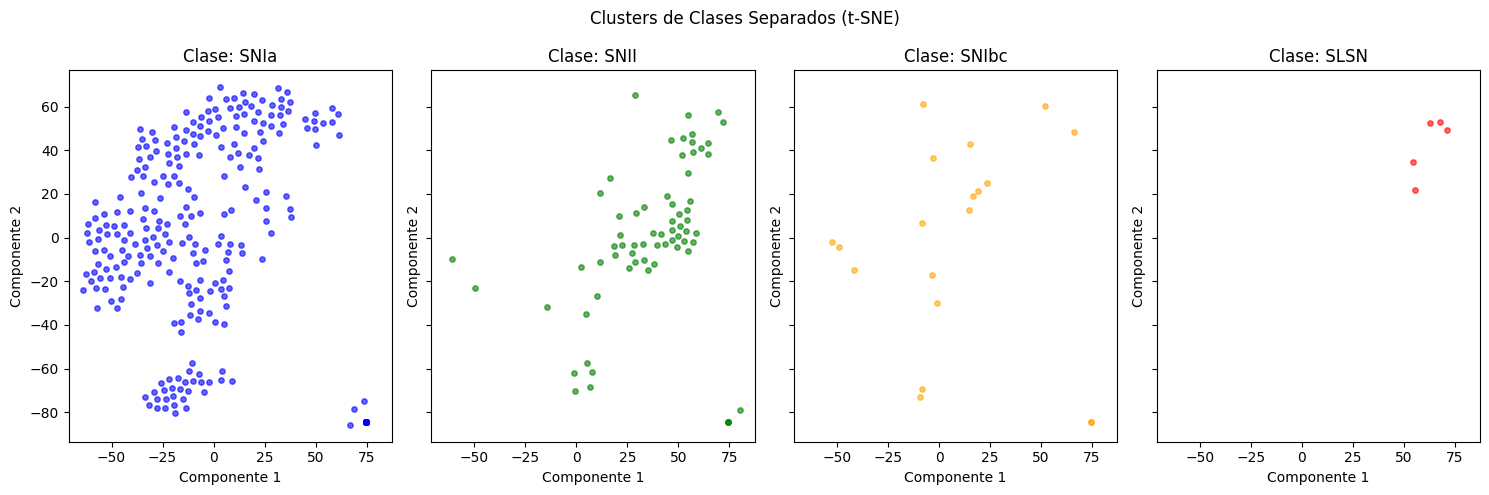

In [ ]:
# Graficar cada clase en un subgráfico separado
num_classes = len(np.unique(labels_test))
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5), sharex=True, sharey=True)

for i, class_id in enumerate(np.unique(labels_test)):
    idxs = labels_test == class_id
    axes[i].scatter(latents_2d_test[idxs, 0], latents_2d_test[idxs, 1],
                    alpha=0.6, s=15, c=colors[class_id])
    axes[i].set_title(f"Clase: {class_mapping[class_id]}")
    axes[i].set_xlabel("Componente 1")
    axes[i].set_ylabel("Componente 2")

plt.suptitle("Clusters de Clases Separados (t-SNE)")
plt.tight_layout()
plt.show()


# **Umap**

In [ ]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


Dimensiones del espacio latente: (1458, 128)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Dimensiones del espacio reducido: (1458, 2)


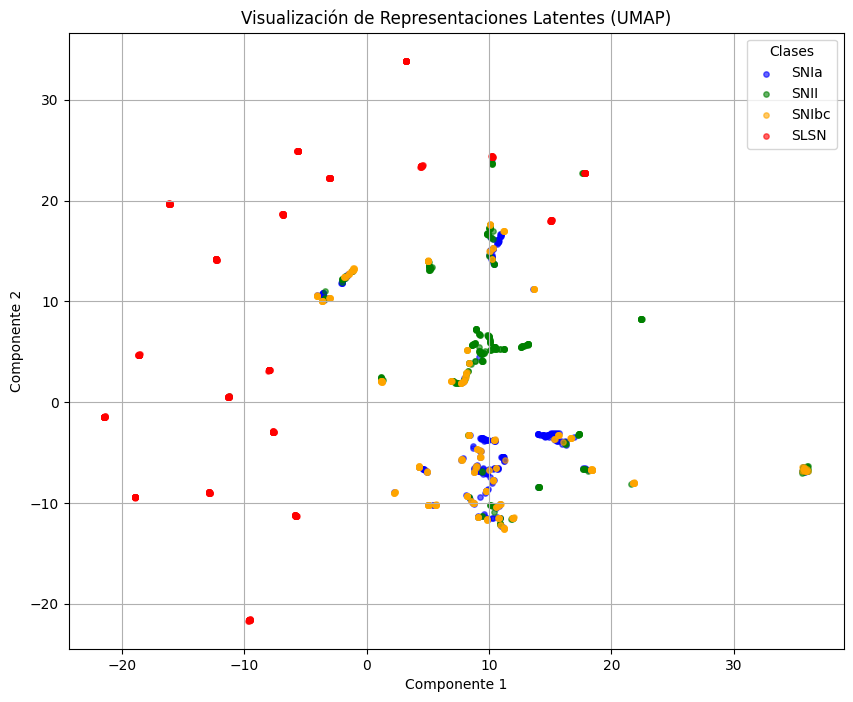

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de entrenamiento
latents = []
labels = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 2 dimensiones usando UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
latents_2d = umap_model.fit_transform(latents)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapeo de clases a etiquetas
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Graficar las representaciones latentes reducidas
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (UMAP)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


Dimensiones del espacio latente: (1458, 128)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensiones del espacio reducido: (1458, 3)


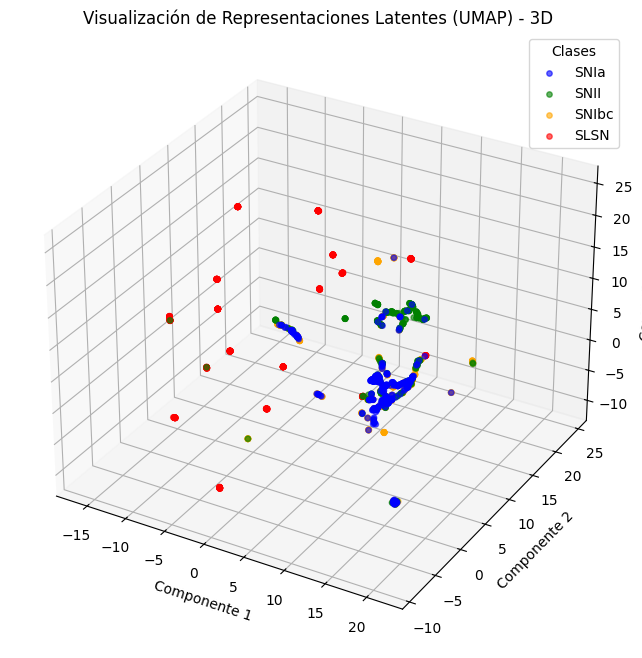

In [ ]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de entrenamiento
latents = []
labels = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)  # Mover a dispositivo (GPU si está disponible)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents.append(latents_batch)  # Almacenar las representaciones
        labels.append(y_batch.numpy())  # Almacenar las etiquetas

# Convertir las listas a arrays numpy
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Reducir a 3 dimensiones usando UMAP
umap_model = umap.UMAP(n_components=3, random_state=42)
latents_3d = umap_model.fit_transform(latents)  # Reducción de la dimensionalidad

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_3d.shape}")

# Mapeo de clases a etiquetas
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}  # Asumiendo que las clases son 0-3
colors = ['blue', 'green', 'orange', 'red']  # Colores para las clases

# Graficar las representaciones latentes reducidas en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for class_id in np.unique(labels):  # Iterar sobre las clases únicas
    idxs = labels == class_id  # Índices donde la clase es igual a 'class_id'
    ax.scatter(latents_3d[idxs, 0], latents_3d[idxs, 1], latents_3d[idxs, 2],  # Coordenadas en 3D
               label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])  # Graficar los puntos

# Títulos y etiquetas
ax.set_title("Visualización de Representaciones Latentes (UMAP) - 3D")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")

# Leyenda y grid
ax.legend(title="Clases")
ax.grid(True)

plt.show()  # Mostrar la gráfica


Dimensiones del espacio latente: (365, 128)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensiones del espacio reducido: (365, 2)


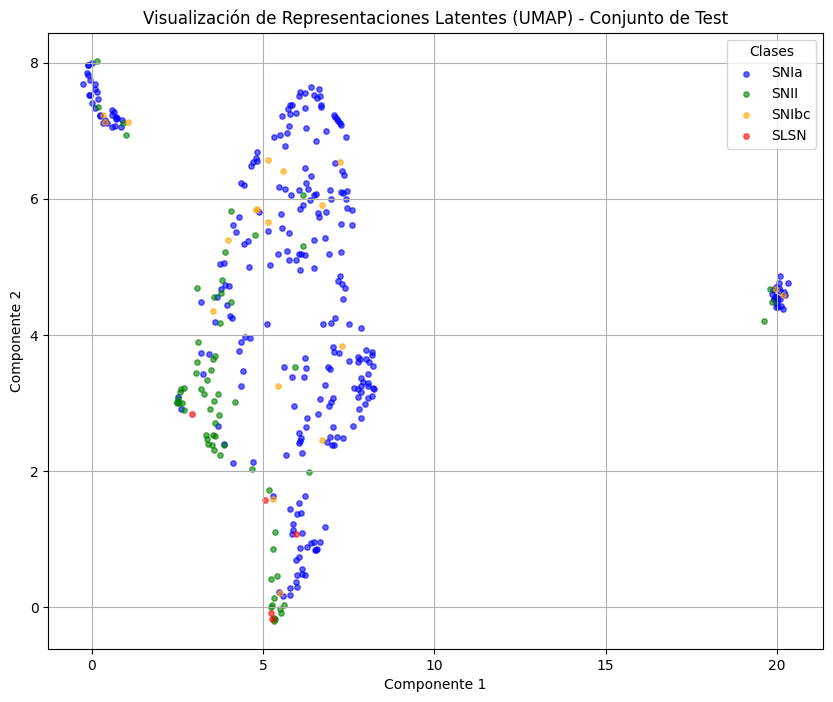

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de test
latents = []
labels = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in test_loader:  # Usamos test_loader en lugar de train_loader
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents.append(latents_batch)
        labels.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents = np.vstack(latents)  # (n_samples, latent_dim)
labels = np.hstack(labels)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente: {latents.shape}")

# Normalizar las representaciones latentes
scaler = StandardScaler()
latents_scaled = scaler.fit_transform(latents)

# Reducir a 2 dimensiones usando UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
latents_2d = umap_model.fit_transform(latents_scaled)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido: {latents_2d.shape}")

# Mapeo de clases a etiquetas
class_mapping = {0: 'SNIa', 1: 'SNII', 2: 'SNIbc', 3: 'SLSN'}
colors = ['blue', 'green', 'orange', 'red']

# Graficar las representaciones latentes reducidas
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels):
    idxs = labels == class_id
    plt.scatter(latents_2d[idxs, 0], latents_2d[idxs, 1],
                label=f"{class_mapping[class_id]}", alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (UMAP) - Conjunto de Test")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


# **Puntos lejanos**

Dimensiones del espacio latente (conjunto de prueba): (365, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Dimensiones del espacio reducido (conjunto de prueba): (365, 2)


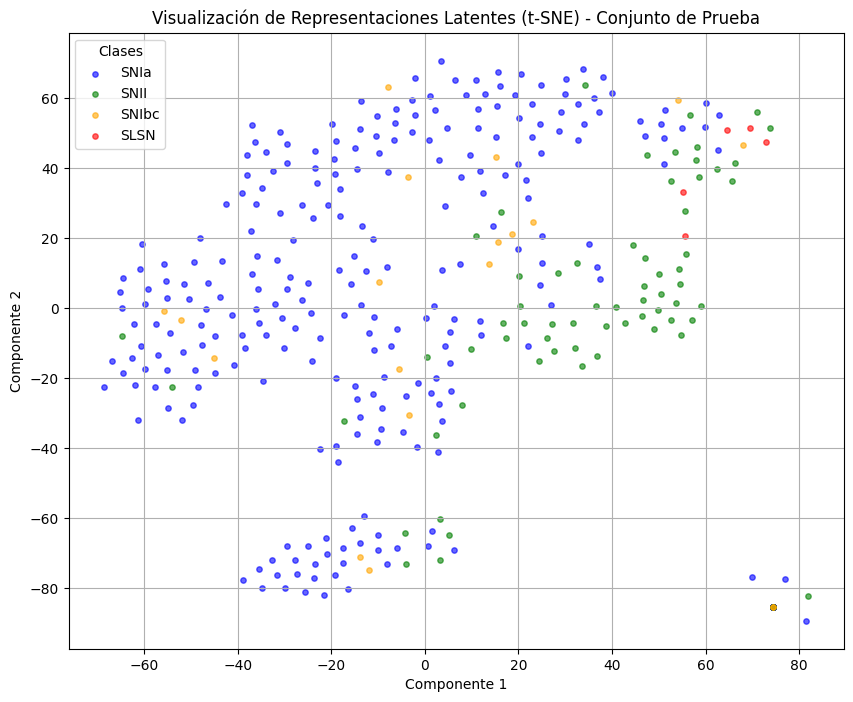

In [ ]:
# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de prueba
latents_test = []
labels_test = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents_test.append(latents_batch)
        labels_test.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents_test = np.vstack(latents_test)  # (n_samples, latent_dim)
labels_test = np.hstack(labels_test)    # (n_samples,)

# Imprimir las dimensiones del espacio latente
print(f"Dimensiones del espacio latente (conjunto de prueba): {latents_test.shape}")

# Reducir a 2 dimensiones usando t-SNE
tsne_test = TSNE(n_components=2, perplexity=30, n_iter=1000)
latents_2d_test = tsne_test.fit_transform(latents_test)

# Imprimir las dimensiones del espacio reducido
print(f"Dimensiones del espacio reducido (conjunto de prueba): {latents_2d_test.shape}")

# Graficar las representaciones latentes reducidas del conjunto de prueba
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels_test):
    idxs = labels_test == class_id
    plt.scatter(latents_2d_test[idxs, 0], latents_2d_test[idxs, 1],
                label=class_mapping[class_id], alpha=0.6, s=15, c=colors[class_id])

plt.title("Visualización de Representaciones Latentes (t-SNE) - Conjunto de Prueba")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()


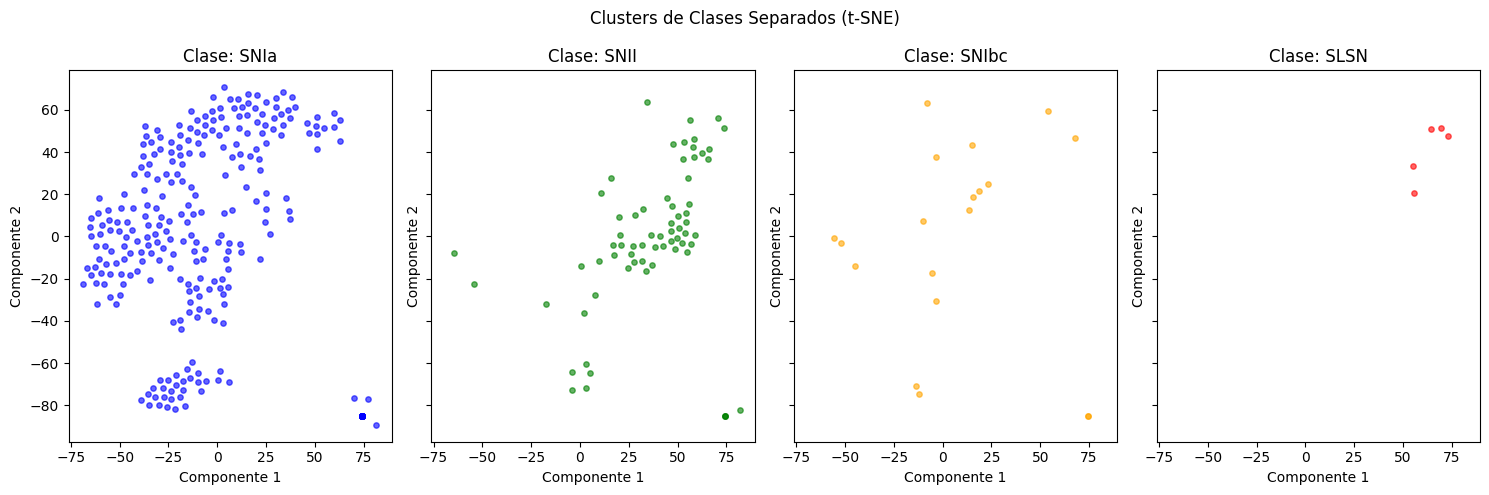

In [ ]:
# Graficar cada clase en un subgráfico separado
num_classes = len(np.unique(labels_test))
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5), sharex=True, sharey=True)

for i, class_id in enumerate(np.unique(labels_test)):
    idxs = labels_test == class_id
    axes[i].scatter(latents_2d_test[idxs, 0], latents_2d_test[idxs, 1],
                    alpha=0.6, s=15, c=colors[class_id])
    axes[i].set_title(f"Clase: {class_mapping[class_id]}")
    axes[i].set_xlabel("Componente 1")
    axes[i].set_ylabel("Componente 2")

plt.suptitle("Clusters de Clases Separados (t-SNE)")
plt.tight_layout()
plt.show()


Clase SNIa:
  Cantidad de elementos: 273
  Puntaje mínimo: 4.8280
  Puntaje máximo: 19.3363
  Puntaje promedio: 7.4219

Clase SNII:
  Cantidad de elementos: 68
  Puntaje mínimo: 5.4444
  Puntaje máximo: 19.4925
  Puntaje promedio: 8.8647

Clase SNIbc:
  Cantidad de elementos: 19
  Puntaje mínimo: 5.5860
  Puntaje máximo: 19.3363
  Puntaje promedio: 8.2421

Clase SLSN:
  Cantidad de elementos: 5
  Puntaje mínimo: 10.3401
  Puntaje máximo: 18.8913
  Puntaje promedio: 14.6998



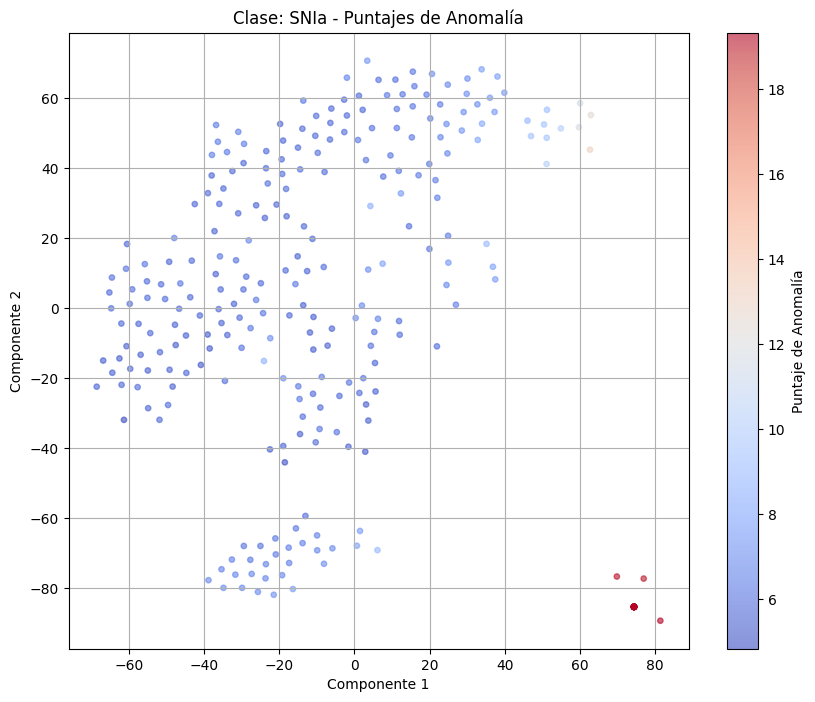

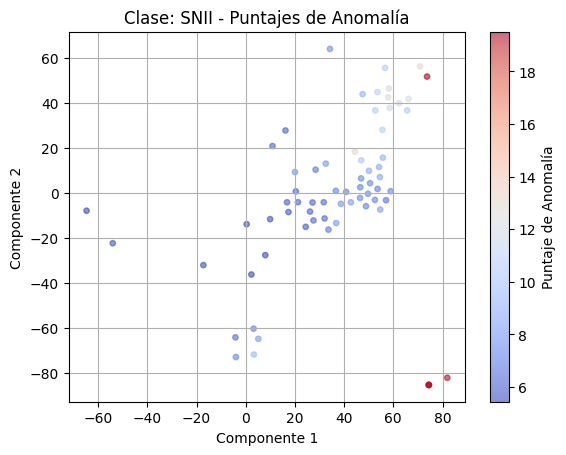

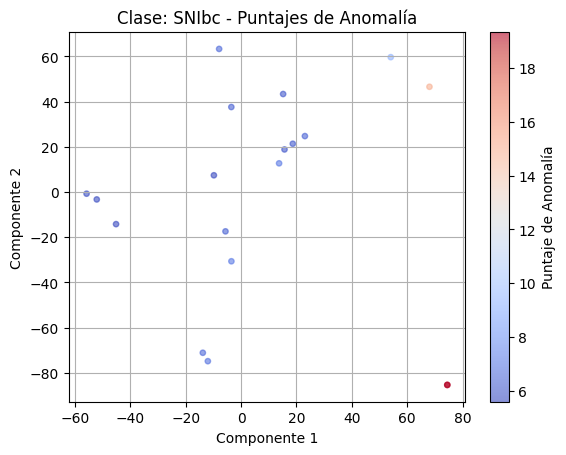

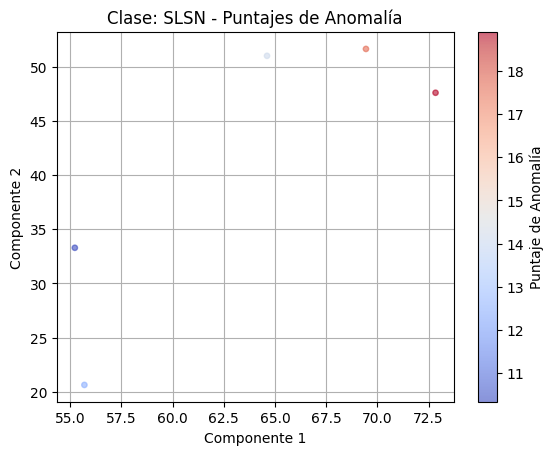

In [ ]:
# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes y etiquetas del conjunto de prueba
latents_test = []
labels_test = []

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Obtener las representaciones latentes
        latents_test.append(latents_batch)
        labels_test.append(y_batch.numpy())

# Convertir las listas a arrays numpy
latents_test = np.vstack(latents_test)  # (n_samples, latent_dim)
labels_test = np.hstack(labels_test)    # (n_samples,)

# Calcular los puntajes de anomalía
with torch.no_grad():
    latents_tensor = torch.tensor(latents_test).to(device)
    distances = torch.sum((latents_tensor.unsqueeze(1) - deep_svdd.c) ** 2, dim=2)  # Distancias a los centros
    anomaly_scores = torch.min(distances, dim=1)[0].cpu().numpy()  # Puntajes de anomalía

# Asociar puntajes de anomalía con clases
class_anomaly_scores = {class_id: [] for class_id in np.unique(labels_test)}
class_counts = {class_id: 0 for class_id in np.unique(labels_test)}

for i, class_id in enumerate(labels_test):
    class_anomaly_scores[class_id].append(anomaly_scores[i])
    class_counts[class_id] += 1

# Resumen de puntajes por clase y cantidad de elementos
for class_id, scores in class_anomaly_scores.items():
    print(f"Clase {class_mapping[class_id]}:")
    print(f"  Cantidad de elementos: {class_counts[class_id]}")
    print(f"  Puntaje mínimo: {np.min(scores):.4f}")
    print(f"  Puntaje máximo: {np.max(scores):.4f}")
    print(f"  Puntaje promedio: {np.mean(scores):.4f}\n")

# Visualizar puntos por clase con sus puntajes de anomalía
plt.figure(figsize=(10, 8))
for class_id in np.unique(labels_test):
    idxs = labels_test == class_id
    plt.scatter(latents_2d_test[idxs, 0], latents_2d_test[idxs, 1],
                c=anomaly_scores[idxs], cmap='coolwarm', alpha=0.6, s=15)
    plt.colorbar(label='Puntaje de Anomalía')
    plt.title(f"Clase: {class_mapping[class_id]} - Puntajes de Anomalía")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.show()


In [ ]:
# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes, etiquetas y los índices originales del conjunto de prueba
latents_test = []
labels_test = []
original_indices = []  # Para guardar los índices originales

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Representaciones latentes
        latents_test.append(latents_batch)
        labels_test.append(y_batch.numpy())

        # Guardar los índices originales de los datos en este lote
        indices = np.arange(batch_idx * len(X_batch), (batch_idx + 1) * len(X_batch))
        original_indices.extend(indices)

# Convertir las listas a arrays numpy
latents_test = np.vstack(latents_test)  # (n_samples, latent_dim)
labels_test = np.hstack(labels_test)    # (n_samples,)
original_indices = np.array(original_indices)  # Índices originales

# Calcular los puntajes de anomalía
with torch.no_grad():
    latents_tensor = torch.tensor(latents_test).to(device)
    distances = torch.sum((latents_tensor.unsqueeze(1) - deep_svdd.c) ** 2, dim=2)  # Distancias a los centros
    anomaly_scores = torch.min(distances, dim=1)[0].cpu().numpy()  # Puntajes de anomalía

# Asociar puntajes de anomalía con clases y guardar los índices originales
class_anomaly_data = {class_id: {'scores': [], 'indices': []} for class_id in np.unique(labels_test)}

for i, class_id in enumerate(labels_test):
    class_anomaly_data[class_id]['scores'].append(anomaly_scores[i])
    class_anomaly_data[class_id]['indices'].append(original_indices[i])

# Resumen y selección de puntos más anómalos
for class_id, data in class_anomaly_data.items():
    scores = np.array(data['scores'])
    indices = np.array(data['indices'])

    # Seleccionar los puntos más anómalos
    top_anomalous_idx = indices[np.argsort(scores)[-5:]]  # Los 5 puntos más anómalos por clase
    print(f"Clase {class_mapping[class_id]}:")
    print(f"  Cantidad de elementos: {len(scores)}")
    print(f"  Puntaje mínimo: {np.min(scores):.4f}")
    print(f"  Puntaje máximo: {np.max(scores):.4f}")
    print(f"  Puntaje promedio: {np.mean(scores):.4f}")
    print(f"  Índices de los puntos más anómalos: {top_anomalous_idx}\n")


Clase SNIa:
  Cantidad de elementos: 273
  Puntaje mínimo: 4.8280
  Puntaje máximo: 19.3363
  Puntaje promedio: 7.4219
  Índices de los puntos más anómalos: [134 143  20  35  94]

Clase SNII:
  Cantidad de elementos: 68
  Puntaje mínimo: 5.4444
  Puntaje máximo: 19.4925
  Puntaje promedio: 8.8647
  Índices de los puntos más anómalos: [312 203 156 126 201]

Clase SNIbc:
  Cantidad de elementos: 19
  Puntaje mínimo: 5.5860
  Puntaje máximo: 19.3363
  Puntaje promedio: 8.2421
  Índices de los puntos más anómalos: [ 24 168 227 288  68]

Clase SLSN:
  Cantidad de elementos: 5
  Puntaje mínimo: 10.3401
  Puntaje máximo: 18.8913
  Puntaje promedio: 14.6998
  Índices de los puntos más anómalos: [302 136 261 269  39]



In [ ]:
# Configuración: modo evaluación
deep_svdd.eval()

# Extraer representaciones latentes, etiquetas y los índices originales del conjunto de prueba
latents_test = []
labels_test = []
original_indices = []  # Para guardar los índices originales

# Usamos torch.no_grad() para no calcular los gradientes durante la evaluación
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(device)
        latents_batch = deep_svdd.encoder(X_batch).cpu().numpy()  # Representaciones latentes
        latents_test.append(latents_batch)
        labels_test.append(y_batch.numpy())

        # Guardar los índices originales de los datos en este lote
        indices = np.arange(batch_idx * len(X_batch), (batch_idx + 1) * len(X_batch))  # Índices globales
        original_indices.extend(indices)

# Convertir las listas a arrays numpy
latents_test = np.vstack(latents_test)  # (n_samples, latent_dim)
labels_test = np.hstack(labels_test)    # (n_samples,)
original_indices = np.array(original_indices)  # Índices originales

# Calcular los puntajes de anomalía
with torch.no_grad():
    latents_tensor = torch.tensor(latents_test).to(device)
    distances = torch.sum((latents_tensor.unsqueeze(1) - deep_svdd.c) ** 2, dim=2)  # Distancias a los centros
    anomaly_scores = torch.min(distances, dim=1)[0].cpu().numpy()  # Puntajes de anomalía

# Asociar puntajes de anomalía con clases y guardar los índices originales
class_anomaly_data = {class_id: {'scores': [], 'indices': []} for class_id in np.unique(labels_test)}

for i, class_id in enumerate(labels_test):
    class_anomaly_data[class_id]['scores'].append(anomaly_scores[i])
    class_anomaly_data[class_id]['indices'].append(original_indices[i])

indices_SNIa = []
indices_SNII = []
indices_SNIbc = []
indices_SLSN = []

# Resumen y selección de puntos más anómalos
for class_id, data in class_anomaly_data.items():
    scores = np.array(data['scores'])
    indices = np.array(data['indices'])

    # Seleccionar los puntos más anómalos
    top_anomalous_idx = indices[np.argsort(scores)[-5:]]  # Los 5 puntos más anómalos por clase
    print(f"Clase {class_mapping[class_id]}:")
    print(f"  Cantidad de elementos: {len(scores)}")
    print(f"  Puntaje mínimo: {np.min(scores):.4f}")
    print(f"  Puntaje máximo: {np.max(scores):.4f}")
    print(f"  Puntaje promedio: {np.mean(scores):.4f}")
    print(f"  Índices originales de los puntos más anómalos: {top_anomalous_idx}\n")

    anomalous_oids = oid_test[top_anomalous_idx]

    if class_mapping[class_id]=='SNIa':
        indices_SNIa.append(top_anomalous_idx)
    elif class_mapping[class_id]=='SNII':
        indices_SNII.append(top_anomalous_idx)
    elif class_mapping[class_id]=='SNIbc':
        indices_SNIbc.append(top_anomalous_idx)
    else:
        indices_SLSN.append(top_anomalous_idx)

    print("OIDs correspondientes a los índices más anómalos:", anomalous_oids)


Clase SNIa:
  Cantidad de elementos: 273
  Puntaje mínimo: 4.8280
  Puntaje máximo: 19.3363
  Puntaje promedio: 7.4219
  Índices originales de los puntos más anómalos: [134 143  20  35  94]

OIDs correspondientes a los índices más anómalos: ['ZTF20abefbiq' 'ZTF18aarcypa' 'ZTF20abeyvwv' 'ZTF19abcupln'
 'ZTF18abvejbm']
Clase SNII:
  Cantidad de elementos: 68
  Puntaje mínimo: 5.4444
  Puntaje máximo: 19.4925
  Puntaje promedio: 8.8647
  Índices originales de los puntos más anómalos: [312 203 156 126 201]

OIDs correspondientes a los índices más anómalos: ['ZTF18absclsr' 'ZTF20aamamnp' 'ZTF19aczmnqy' 'ZTF19abqrxhy'
 'ZTF18abuicad']
Clase SNIbc:
  Cantidad de elementos: 19
  Puntaje mínimo: 5.5860
  Puntaje máximo: 19.3363
  Puntaje promedio: 8.2421
  Índices originales de los puntos más anómalos: [ 24 168 227 288  68]

OIDs correspondientes a los índices más anómalos: ['ZTF19aatheus' 'ZTF18abeyqpr' 'ZTF19aanijpu' 'ZTF19abjnuro'
 'ZTF19acxpqgh']
Clase SLSN:
  Cantidad de elementos: 5
  Pun

## Graficar Puntos Lejanos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapeo de filtro (fid) a nombre de banda y colores/símbolos
fid_to_band = {1: "g", 2: "r"}
band_to_marker = {"g": "o", "r": "s"}  # Círculo para g, cuadrado para r
band_to_color = {"g": "limegreen", "r": "red"}  # Colores para bandas
band_to_maglim_marker = {"g": "^", "r": "v"}  # Triángulos para límites de magnitud

# Función para graficar una supernova específica basada en su OID
def plot_light_curve_for_oid_with_symbols(oid):
    # Filtrar las detecciones para el objeto con el OID especificado
    object_data = df_detections[df_detections['objectId'] == oid]

    if object_data.empty:
        print(f"No se encontraron datos para el objeto con OID: {oid}")
        return

    plt.figure(figsize=(8, 6))

    # Graficar para cada banda
    for fid, band in fid_to_band.items():
        band_data = object_data[object_data['fid'] == fid]
        if not band_data.empty:
            # Magnitudes
            plt.scatter(
                band_data['mjd'], band_data['magpsf'],
                label=f"{band}", alpha=0.8, s=50,
                color=band_to_color[band], marker=band_to_marker[band]
            )
            # Límites de magnitud
            plt.scatter(
                band_data['mjd'], band_data['magpsf'] + band_data['sigmapsf'],
                label=f"maglim {band}", alpha=0.5, s=40,
                color=band_to_color[band], marker=band_to_maglim_marker[band]
            )

    plt.gca().invert_yaxis()  # Invertir eje Y porque magnitud disminuye al ser más brillante
    plt.title(f"Curva de luz para el objeto {oid}")
    plt.xlabel("MJD (Tiempo en días julianos modificados)")
    plt.ylabel("Diferencia de Magnitud")
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.show()

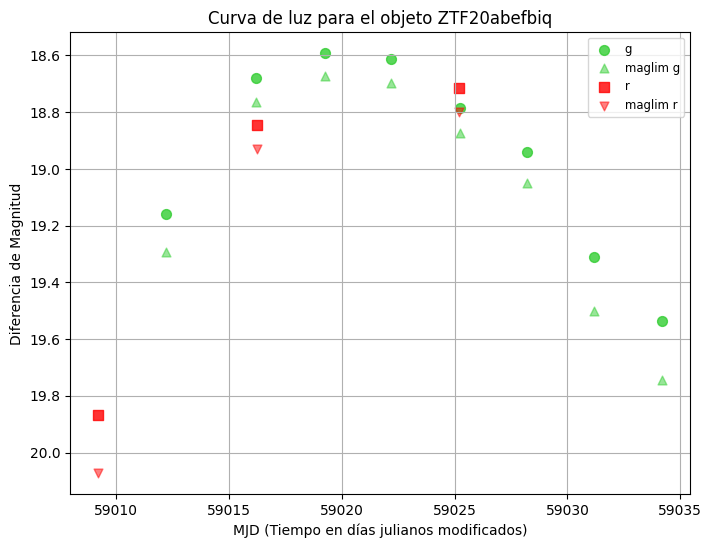

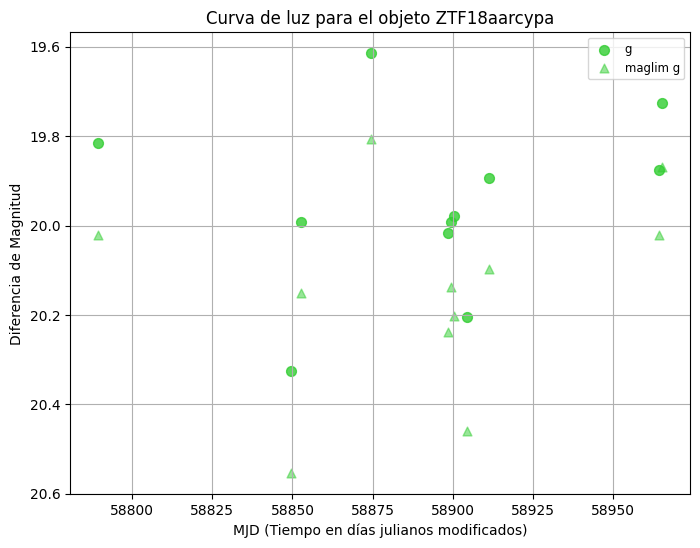

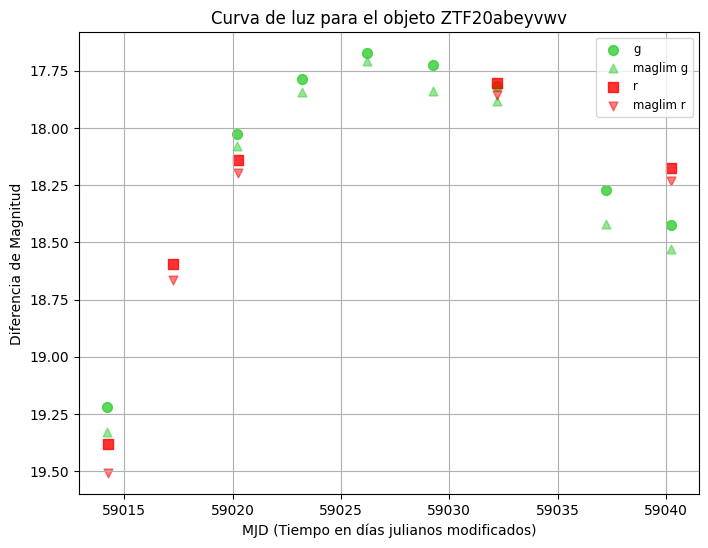

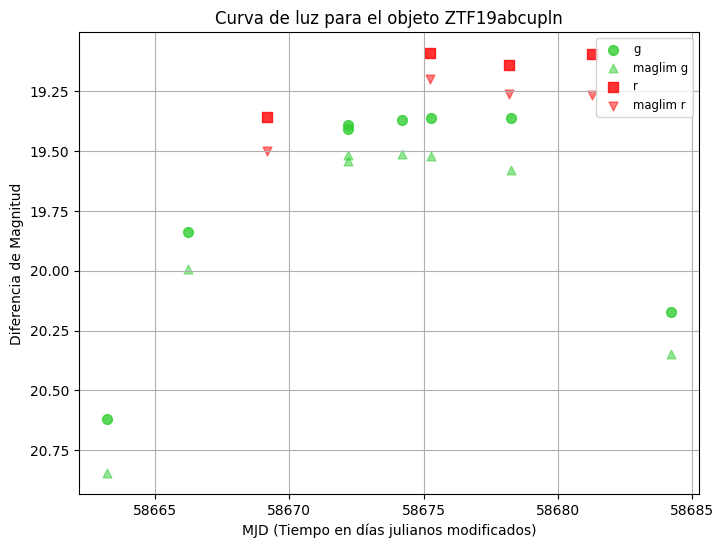

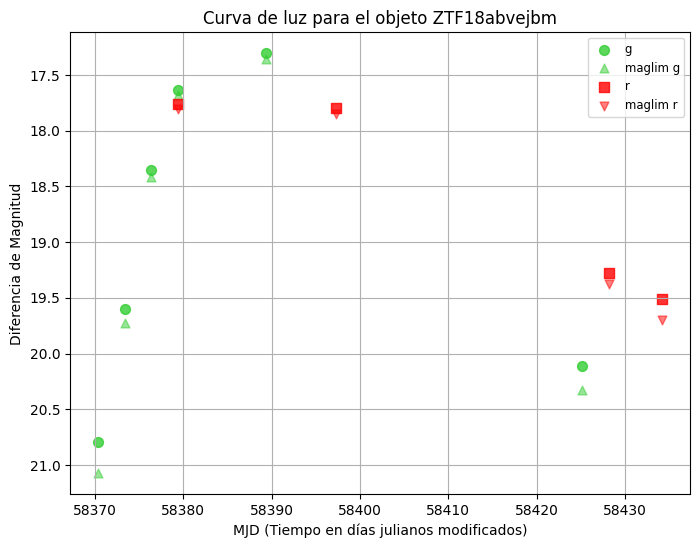

In [ ]:
# Curvas de luz SNIa
for idx in indices_SNIa[0].tolist():
    oid = oid_test[idx]
    plot_light_curve_for_oid_with_symbols(oid)

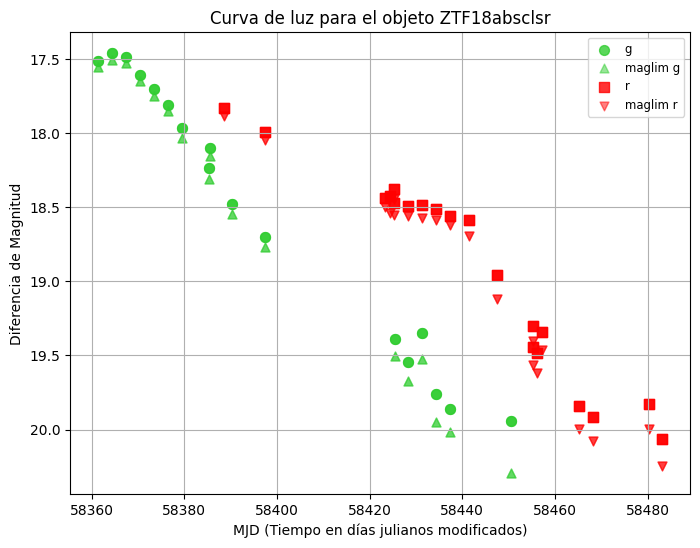

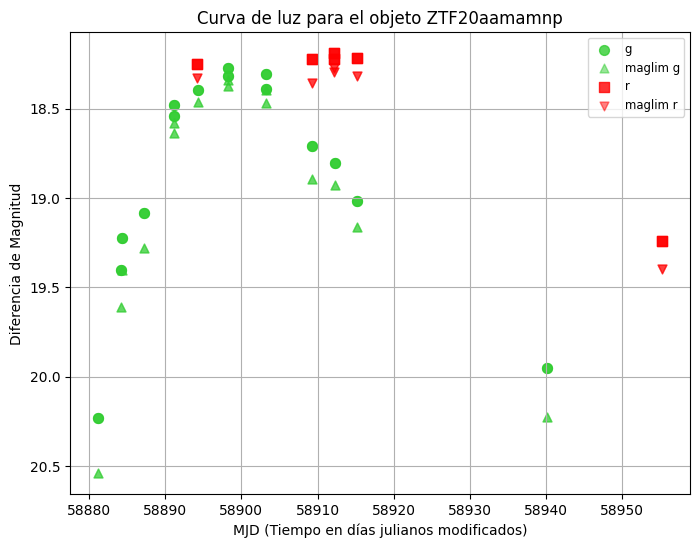

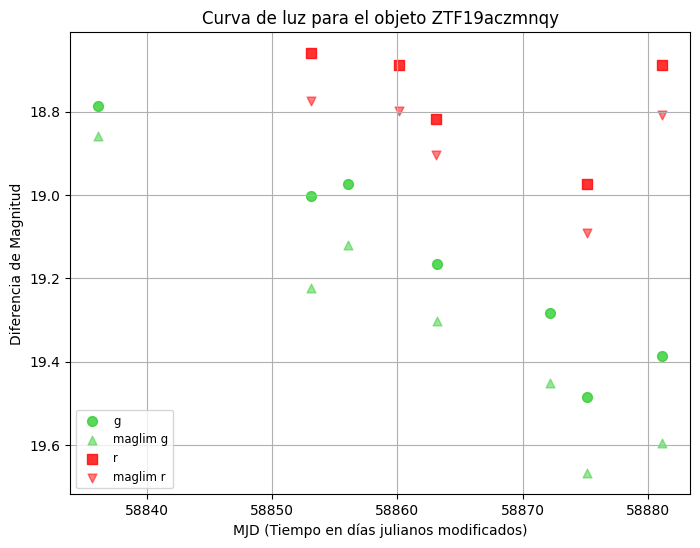

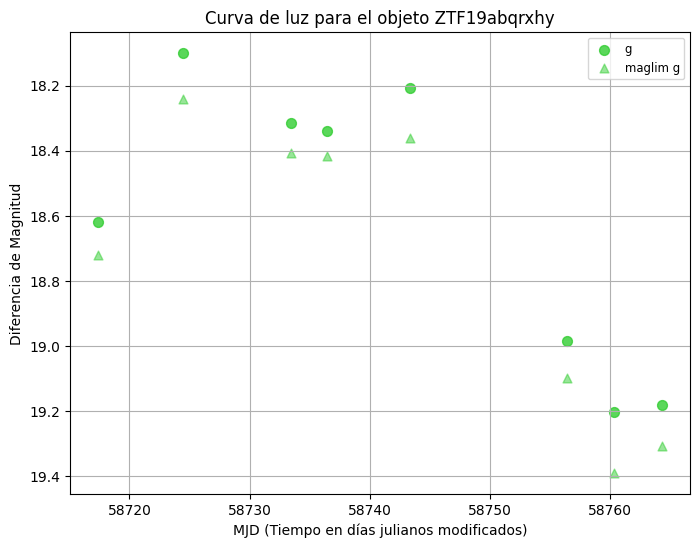

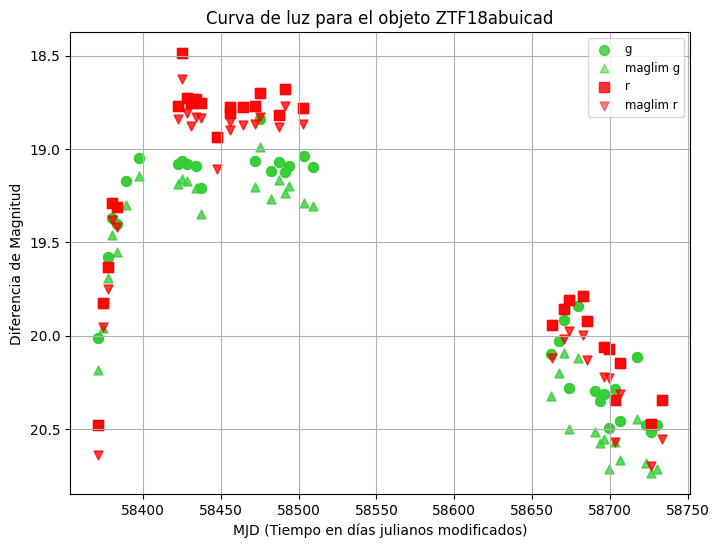

In [ ]:
# Curvas de luz SNII
for idx in indices_SNII[0].tolist():
    oid = oid_test[idx]
    plot_light_curve_for_oid_with_symbols(oid)

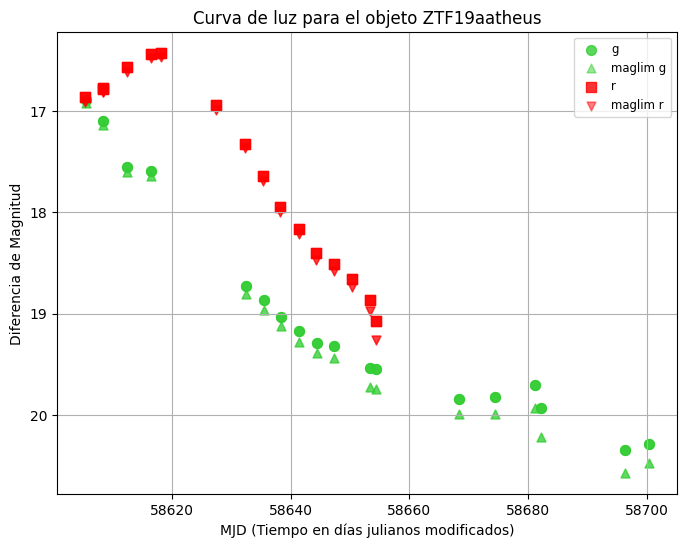

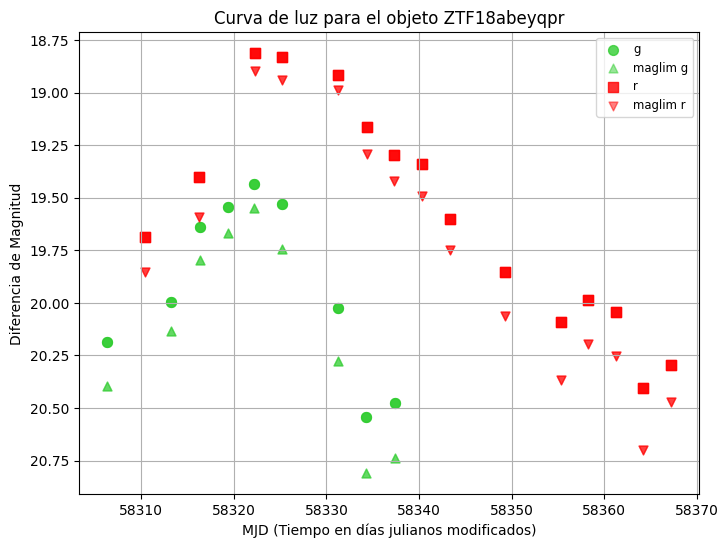

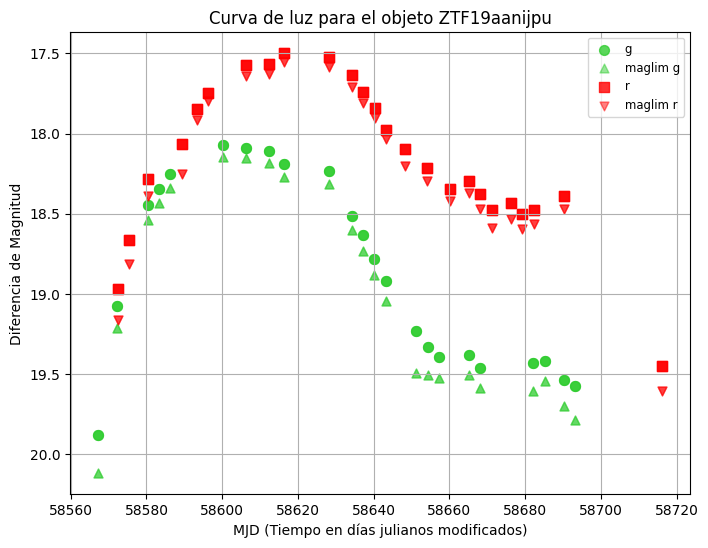

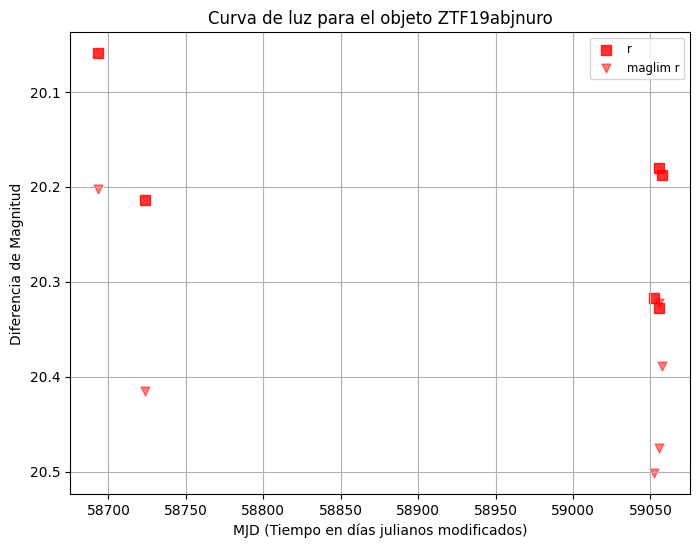

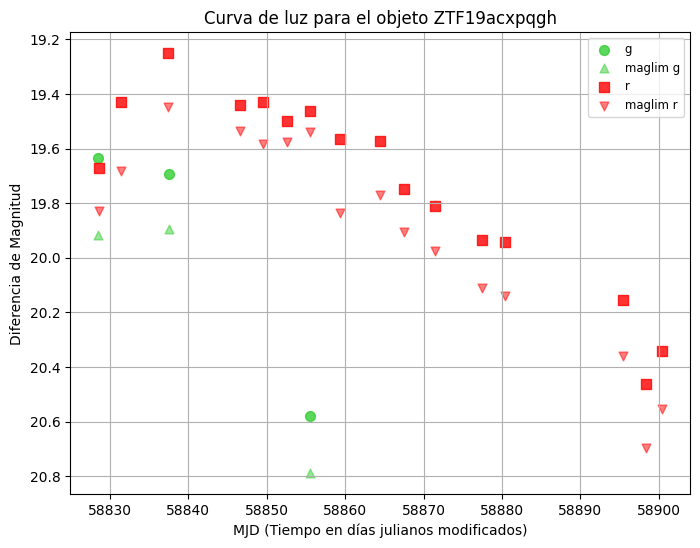

In [ ]:
# Curvas de luz SNIbc
for idx in indices_SNIbc[0].tolist():
    oid = oid_test[idx]
    plot_light_curve_for_oid_with_symbols(oid)

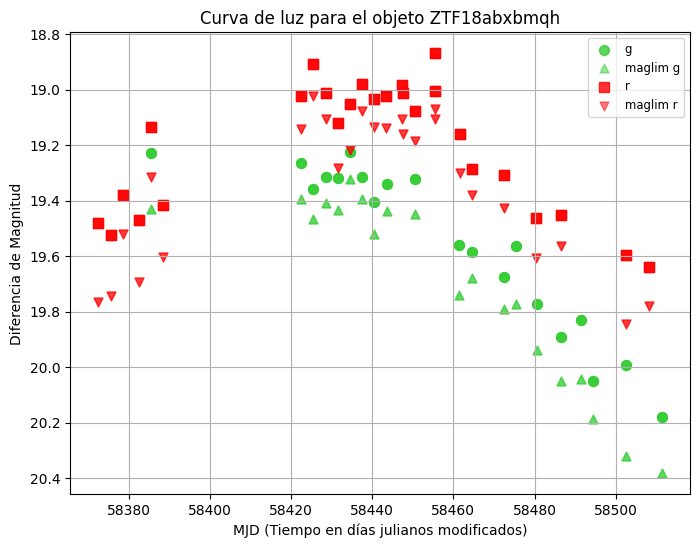

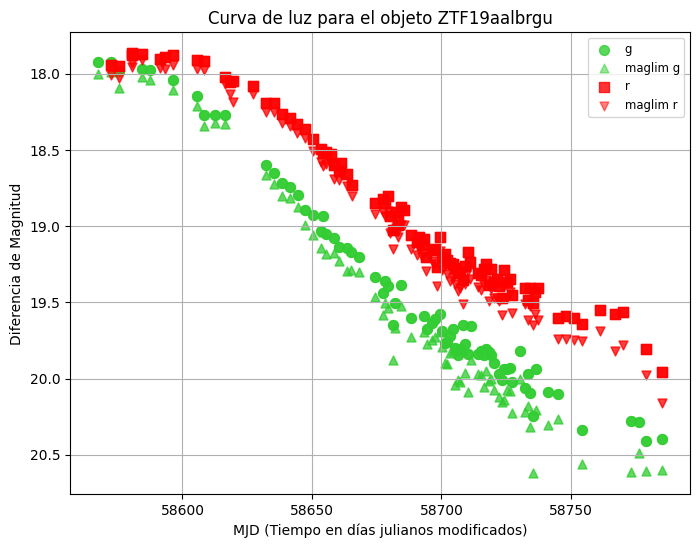

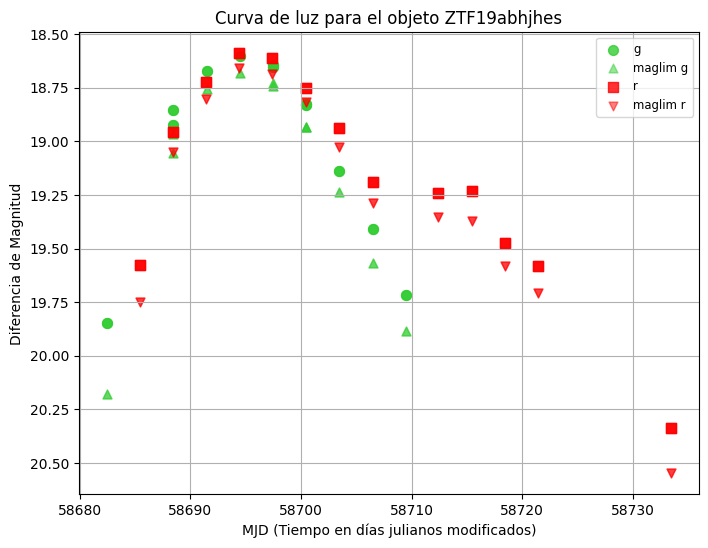

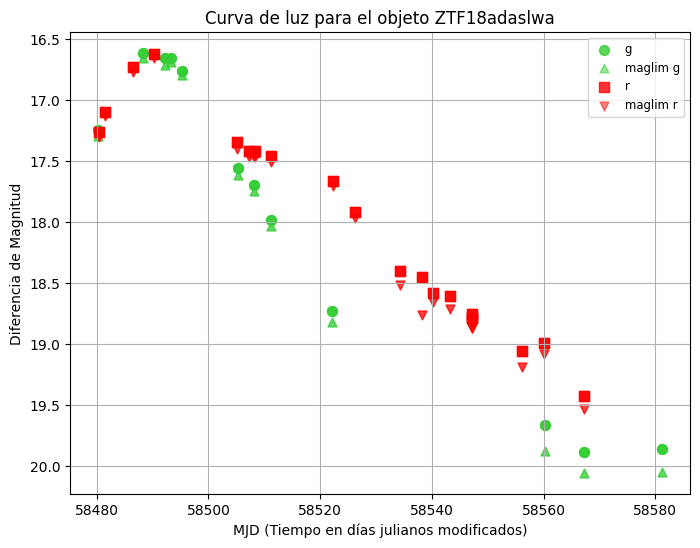

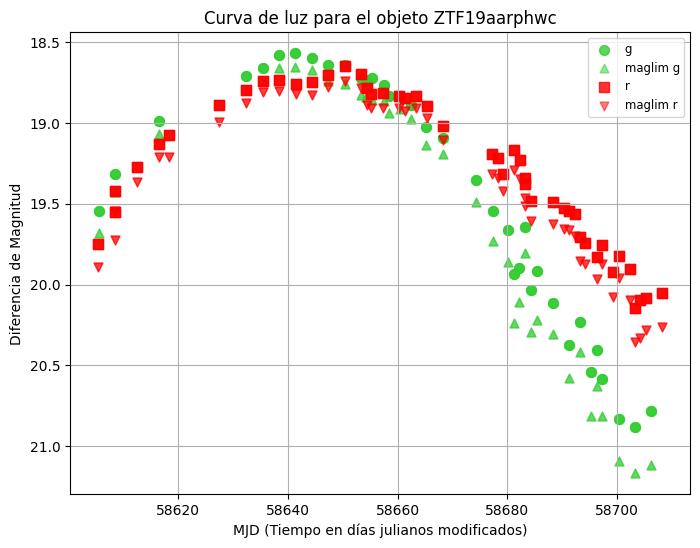

In [ ]:
# Curvas de luz SLSN
for idx in indices_SLSN[0].tolist():
    oid = oid_test[idx]
    plot_light_curve_for_oid_with_symbols(oid)

In [ ]:
# Resumen y selección de puntos con puntajes más bajos de anomalía (mínimos)
for class_id, data in class_anomaly_data.items():
    scores = np.array(data['scores'])
    indices = np.array(data['indices'])

    # Seleccionar los puntos con los puntajes más bajos (mínimos) de anomalía
    top_anomalous_idx_min = indices[np.argsort(scores)[:5]]  # Los 5 puntos con los menores puntajes de anomalía por clase
    print(f"Clase {class_mapping[class_id]}:")
    print(f"  Cantidad de elementos: {len(scores)}")
    print(f"  Puntaje mínimo: {np.min(scores):.4f}")
    print(f"  Puntaje máximo: {np.max(scores):.4f}")
    print(f"  Puntaje promedio: {np.mean(scores):.4f}")
    print(f"  Índices originales de los puntos con menor puntaje de anomalía: {top_anomalous_idx_min}\n")

    anomalous_oids_min = oid_test[top_anomalous_idx_min]

    print("OIDs correspondientes a los índices con menor puntaje de anomalía:", anomalous_oids_min)


Clase SNIa:
  Cantidad de elementos: 273
  Puntaje mínimo: 4.8280
  Puntaje máximo: 19.3363
  Puntaje promedio: 7.4219
  Índices originales de los puntos con menor puntaje de anomalía: [214  18  15 255 157]

OIDs correspondientes a los índices con menor puntaje de anomalía: ['ZTF19abkdeae' 'ZTF20aafxrcv' 'ZTF20aakxzut' 'ZTF20abeoicg'
 'ZTF19aavyafo']
Clase SNII:
  Cantidad de elementos: 68
  Puntaje mínimo: 5.4444
  Puntaje máximo: 19.4925
  Puntaje promedio: 8.8647
  Índices originales de los puntos con menor puntaje de anomalía: [ 54 253 186 228 182]

OIDs correspondientes a los índices con menor puntaje de anomalía: ['ZTF20aamlmec' 'ZTF20aayxdse' 'ZTF19abfloxk' 'ZTF19aaknate'
 'ZTF19abpnrrf']
Clase SNIbc:
  Cantidad de elementos: 19
  Puntaje mínimo: 5.5860
  Puntaje máximo: 19.3363
  Puntaje promedio: 8.2421
  Índices originales de los puntos con menor puntaje de anomalía: [ 77 308 153 299 239]

OIDs correspondientes a los índices con menor puntaje de anomalía: ['ZTF19aavkvpw' 'ZTF